# Análisis de precios de Airbnb en Madrid

<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Airbnb_Logo_B%C3%A9lo.svg/2560px-Airbnb_Logo_B%C3%A9lo.svg.png" width="300">
</div>

## Objetivo del proyecto

Este proyecto tiene como objetivo analizar los factores que influyen en los precios de los alojamientos de Airbnb en Madrid, con especial foco en el perfil de propiedades de nuestro cliente.

Mediante técnicas de análisis de datos y modelos predictivos, buscaremos entender:

- ¿Qué características de las propiedades tienen mayor impacto en el precio?
- ¿Cómo influye la ubicación en el coste de los alojamientos?
- ¿Existe una correlación entre las valoraciones de los huéspedes y los precios?
- ¿Qué diferencias hay entre las propiedades de los Superhosts y los anfitriones regulares?
- ¿Cuál sería el precio óptimo para las propiedades de nuestro cliente según sus características?

## Metodología

El proyecto seguirá estos pasos:

1. **Exploración y limpieza de datos**: Análisis de valores nulos, duplicados y outliers
2. **Análisis exploratorio**: Distribución de precios, relaciones entre variables
3. **Visualización**: Mapas de calor de precios por zonas, gráficos de correlación
4. **Segmentación**: Análisis específico del segmento de apartamentos de 1-3 habitaciones con precio menor a 200€
5. **Modelado**: Predicción de precios basada en las características de las propiedades
6. **Conclusiones**: Recomendaciones para optimizar el precio de los apartamentos del cliente


# 0. Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.mathjax = None 
import folium
from folium.plugins import HeatMap
import os
from IPython.display import Image, display
from ydata_profiling import ProfileReport
from scipy import stats
import kaleido
import warnings
warnings.simplefilter("ignore")

# Configurar la visualización de DataFrame
pd.set_option('display.max_columns', None)
# Configurar el estilo de las visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# 1. Datos

El análisis se basa en un conjunto de datos que incluye información sobre más de 21,000 propiedades en Madrid, con detalles sobre:

- **Condiciones**: precio, noches mínimas/máximas, políticas de cancelación
- **Anfitriones**: tiempo de respuesta, tasa de respuesta, estado de Superhost, verificaciones
- **Ubicación**: vecindario, coordenadas, distancia a puntos de interés
- **Propiedades**: tipo de propiedad, tipo de habitación, capacidad, comodidades
- **Reseñas**: puntuaciones, cantidad de reseñas, idiomas de las reseñas

In [2]:
# Directorio donde están los archivos parquet
data_dir = '../data/' 

# Crear un diccionario para almacenar los dataframes
dataframes = {}

# Leer todos los archivos parquet en el directorio
for file in os.listdir(data_dir):
    if file.endswith('.parquet'):
        file_path = os.path.join(data_dir, file)
        # Usar el nombre del archivo (sin la extensión) como clave del diccionario
        df_name = os.path.splitext("df_" + ("".join(list(file.split ("_")[-1]))))[0]
        # Leer el archivo parquet
        dataframes[df_name] = pd.read_parquet(file_path)
        print(f"Archivo {file} leído correctamente")

# Mostrar los nombres de los dataframes disponibles
print("\nDataframes disponibles:")
for name in dataframes.keys():
    print(f"- {name}")

Archivo airbnb_madrid_conditions.parquet leído correctamente
Archivo airbnb_madrid_host.parquet leído correctamente
Archivo airbnb_madrid_location.parquet leído correctamente
Archivo airbnb_madrid_property.parquet leído correctamente
Archivo airbnb_madrid_reviews.parquet leído correctamente

Dataframes disponibles:
- df_conditions
- df_host
- df_location
- df_property
- df_reviews


In [3]:
# Definir los dataframes específicos para uso posterior
df_conditions = dataframes['df_conditions']
df_host = dataframes['df_host']
df_location = dataframes['df_location']
df_property = dataframes['df_property']
df_reviews = dataframes['df_reviews']

# Inspección inicial de cada dataframe
print("\n" + "="*50)
print("INSPECCIÓN INICIAL DE DATAFRAMES")
print("="*50)

for name, df in dataframes.items():
    print(f"\n{'-'*40}")
    print(f"Dataframe: {name}")
    print(f"{'-'*40}")
    
    # Forma del dataframe (filas, columnas)
    print(f"Shape: {df.shape} (filas, columnas)")
    
    # Nombres de las columnas
    print(f"\nColumnas: {list(df.columns)}")
    
    # Tipos de datos
    print("\nTipos de datos:")
    print(df.dtypes)
    
    # Valores nulos
    null_count = df.isnull().sum()
    print("\nValores nulos por columna:")
    print(null_count[null_count > 0] if null_count.any() > 0 else "No hay valores nulos")
    
    # Duplicados
    duplicates = df.duplicated().sum()
    print(f"\nFilas duplicadas: {duplicates}")
    
    # Posibles columnas de clave (suponiendo que son columnas con valores únicos)
    unique_cols = []
    for col in df.columns:
        if df[col].nunique() == len(df):
            unique_cols.append(col)
    print("\nPosibles columnas clave (valores únicos):")
    print(unique_cols if unique_cols else "No se encontraron columnas con valores únicos")
    
    # Muestra de los primeros registros
    print("\nPrimeras 3 filas:")
    print(df.head(3))

print("\n" + "="*50)
print("RESUMEN DE POSIBLES CLAVES PARA MERGE")
print("="*50)
for name, df in dataframes.items():
    unique_cols = [col for col in df.columns if df[col].nunique() == len(df)]
    print(f"{name}: {unique_cols}")


INSPECCIÓN INICIAL DE DATAFRAMES

----------------------------------------
Dataframe: df_conditions
----------------------------------------
Shape: (21020, 7) (filas, columnas)

Columnas: ['id', 'price', 'minimum_nights', 'maximum_nights', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']

Tipos de datos:
id                                    int64
price                               float64
minimum_nights                        int64
maximum_nights                        int64
cancellation_policy                  object
require_guest_profile_picture         int64
require_guest_phone_verification      int64
dtype: object

Valores nulos por columna:
No hay valores nulos

Filas duplicadas: 0

Posibles columnas clave (valores únicos):
['id']

Primeras 3 filas:
   id  price  minimum_nights  maximum_nights          cancellation_policy  \
0   0   70.0               1             365                     flexible   
1   1   17.0               4       

In [4]:
# Merge de todos los dataframes usando la columna 'id'
df = df_conditions.merge(df_host, on='id', how='left')\
                        .merge(df_location, on='id', how='left')\
                        .merge(df_property, on='id', how='left')\
                        .merge(df_reviews, on='id', how='left')

# Verificamos el shape del dataframe resultante
print(f"Shape del dataframe merged: {df.shape}")

# Verificamos que no hemos perdido filas
print(f"Número de filas original: {len(df_conditions)}")
print(f"Número de filas después del merge: {len(df)}")

# Verificamos que tenemos todas las columnas
print(f"Número total de columnas esperadas (sin repetir 'id'): {sum([df_.shape[1] for df_ in dataframes.values()]) - 4*1}")  
print(f"Número de columnas después del merge: {df.shape[1]}")
# Verificamos valores nulos en el dataframe resultante
null_counts = df.isnull().sum()
print("\nValores nulos en el dataframe merged:")
print(null_counts[null_counts > 0])

Shape del dataframe merged: (21020, 52)
Número de filas original: 21020
Número de filas después del merge: 21020
Número total de columnas esperadas (sin repetir 'id'): 52
Número de columnas después del merge: 52

Valores nulos en el dataframe merged:
host_response_time             4464
host_response_rate             4464
review_scores_rating           4294
review_scores_accuracy         4295
review_scores_cleanliness      4293
review_scores_checkin          4292
review_scores_communication    4292
review_scores_location         4295
review_scores_value            4296
reviews_per_month              4038
number_of_reviews_en           4038
number_of_reviews_es           4038
number_of_reviews_otros        4038
dtype: int64


In [5]:
# profile incluida en la carpeta docs
# profile = ProfileReport(df, title="Airbnb_Madrid_Report", explorative=True)
# profile.to_file(os.path.join("..", "docs", "Airbnb_Madrid_Report.html"))

In [6]:
print(f"Columnas numéricas analizadas: {df.select_dtypes(include=['number']).shape[1]}")
display(df.describe())

print(f"\nColumnas categóricas y otras analizadas: {df.select_dtypes(exclude=['number']).shape[1]}")
display(df.describe(include=['O']))


Columnas numéricas analizadas: 45


,id,price,minimum_nights,maximum_nights,require_guest_profile_picture,require_guest_phone_verification,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,host_verifications_email,host_verifications_phone,host_verifications_reviews,host_verifications_facebook,host_verifications_government_id,calculated_host_listings_count,host_seniority,latitude,longitude,dist_km_sol,dist_km_airport,accommodates,bathrooms,bedrooms,beds,amenities_wifi_internet,amenities_tv,amenities_air_conditioning,amenities_heating,amenities_kitchen,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,days_since_last_review,days_since_first_review,number_of_reviews_en,number_of_reviews_es,number_of_reviews_otros
count,21020.000000,21020.000000,21020.000000,2.102000e+04,21020.000000,21020.000000,16556.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.00000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,21020.000000,16726.000000,16725.000000,16727.000000,16728.000000,16728.000000,16725.000000,16724.000000,16982.000000,21020.000000,21020.000000,16982.000000,16982.000000,16982.000000
mean,10644.643911,131.326213,4.414843,1.276126e+03,0.009420,0.014891,94.249577,0.203330,0.996432,0.299286,0.936013,0.994291,0.593815,0.140913,0.690200,11.54648,1323.182112,40.420573,-3.694190,3.921288,13.717463,3.300333,1.299096,1.354282,1.984348,0.955804,0.790676,0.630304,0.886156,0.903378,38.126546,14.928592,92.195923,9.506428,9.363305,9.612446,9.634027,9.651659,9.164016,1.981618,115.318078,589.228164,22.673713,17.225651,7.292957
std,6148.700224,364.802634,21.745342,7.664670e+04,0.096599,0.121118,15.582639,0.402486,0.059628,0.457956,0.244735,0.075343,0.491131,0.347940,0.462422,32.29336,813.118385,0.021976,0.027998,2.824069,2.665593,2.020460,0.726359,0.860747,1.535594,0.205535,0.406836,0.482734,0.317629,0.295450,65.800453,21.980680,9.327667,0.908534,0.975032,0.844823,0.827919,0.722439,0.996709,1.960734,254.284152,623.833891,38.832393,25.328713,12.089131
min,0.000000,1.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,-1.000000,40.332470,-3.835500,0.000000,0.720670,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,5318.750000,40.000000,1.000000,4.000000e+01,0.000000,0.000000,97.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,624.000000,40.409510,-3.707460,1.930370,13.081924,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,90.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.450000,5.000000,66.000000,2.000000,2.000000,0.000000
50%,10632.500000,65.000000,2.000000,1.125000e+03,0.000000,0.000000,100.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.00000,1279.000000,40.419090,-3.701150,2.815954,13.998700,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,4.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.350000,20.000000,396.000000,7.000000,7.000000,2.000000
75%,15965.250000,102.000000,3.000000,1.125000e+03,0.000000,0.000000,100.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,7.00000,1880.000000,40.429050,-3.688470,5.292589,14.845695,4.000000,1.500000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45.000000,22.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Columnas categóricas y otras analizadas: 7


,cancellation_policy,host_response_time,neighbourhood,neighbourhood_group,property_type,room_type,bed_type
count,21020,16556,21020,21020,21020,21020,21020
unique,5,4,66,21,30,4,5
top,strict_14_with_grace_period,within_an_hour,Centro,Centro,apartment,entire_home_apt,real_bed
freq,7425,12288,5058,9804,17180,12913,20855


# 2. Requisitos de cliente
Este proyecto busca analizar los factores que impactan en los precios de los alojamientos de Airbnb en Madrid, con un enfoque especial en el perfil de propiedades de nuestro cliente, quien posee este tipo de pisos y está interesado en optimizar sus tarifas y ampliar su cartera basándose en el análisis

- **Tipo de propiedad**: Apartamentos
- **Localización**: Todos los barrios de Madrid
- **Número de habitaciones**: De 1 a 3 habitaciones
- **Rango de precio**: "no lujo"

In [7]:
# Seleccionar los apartamentos de 1 a 3 habitaciones para normalizar precios y hacer comparaciones más justas con apartamentos enteros. 
print(df.shape)
df = df[(df["property_type"] =="apartment") & (df["bedrooms"].between(1, 3))]
df.drop(columns=["property_type"], inplace=True)
print(df.shape)

(21020, 52)
(15651, 51)


In [8]:
# Se recalcula el precio de los apartamentos teniendo en cuenta el número de habitaciones
mask_room = (df.room_type != 'entire_home_apt') & (df.bedrooms > 1)
df.loc[mask_room, "price"] = df.loc[mask_room, "price"] * df.loc[mask_room, "bedrooms"]


In [9]:
# Buscar un ID que cumpla la condición antes del cambio
id_test = df.loc[
    (df.room_type != 'entire_home_apt') & (df.bedrooms > 1), 
    ["id", "room_type", "bedrooms", "price"]
].head(1)  # Tomamos solo uno para verificar

if not id_test.empty:
    property_id_test = id_test.iloc[0]["id"]

    # Mostrar los valores antes de la modificación para ese ID
    print("ANTES de la modificación:")
    print(df[df.id == property_id_test][["id", "room_type", "bedrooms", "price"]])

    # Aplicar la modificación
    mask_room = (df.room_type != 'entire_home_apt') & (df.bedrooms > 1)
    df.loc[mask_room, "price"] = df.loc[mask_room, "price"] * df.loc[mask_room, "bedrooms"]

    # Mostrar los valores después de la modificación para el mismo ID
    print("\nDESPUÉS de la modificación:")
    print(df[df.id == property_id_test][["id", "room_type", "bedrooms", "price"]])
else:
    print("No se encontraron propiedades que cumplan la condición.")


ANTES de la modificación:
    id     room_type  bedrooms  price
72  73  private_room       3.0   87.0

DESPUÉS de la modificación:
    id     room_type  bedrooms  price
72  73  private_room       3.0  261.0


In [10]:
# Variable de control para ejecutar solo una vez
if "outliers_eliminados" not in globals():
    outliers_eliminados = False

if not outliers_eliminados:
    # Se localizan los outliers y para seleccionar los apartamentos "no lujo" 
    # eliminamos los outliers del límite superior.
    variable_analisis = 'price'
    Q1 = np.percentile(df[variable_analisis], 25)
    Q3 = np.percentile(df[variable_analisis], 75)

    IQR = Q3 - Q1

    print('Valor del primer cuartil (25%): {:.2f}'.format(Q1))
    print('Valor del tercer cuartil (75%): {:.2f}'.format(Q3))
    print('Valor del rango intercuartil (IQR): {:.2f}'.format(IQR))

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print('\n')
    print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
    print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
    print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")
    print('\n')

    # Se eliminan los outliers del límite superior
    df = df[df[variable_analisis] <= limite_superior]

    # Marcar que ya se ejecutó
    outliers_eliminados = True  

    print(f"Se eliminaron los valores mayores a {limite_superior:.2f} en '{variable_analisis}'.")
    print(f"Nuevo tamaño del DataFrame: {df.shape}")
else:
    print("⚠️ La eliminación de outliers ya se ejecutó una vez. No se realizará nuevamente.")


Valor del primer cuartil (25%): 40.00
Valor del tercer cuartil (75%): 101.00
Valor del rango intercuartil (IQR): 61.00


Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:
	 - Límite inferior (considerado extremadamente bajo): -51.50
	 - Límite superior (considerado extremadamente alto): 192.50


Se eliminaron los valores mayores a 192.50 en 'price'.
Nuevo tamaño del DataFrame: (14085, 51)


Nuestro cliente nos ha solicitazo optimizar el precio de sus viviendas. Calculamos el **precio óptimo** de las viviendas que están en el rango de precios más altos (superior al 90% de los precios). 

In [11]:
# Se crea columna precio_optimo para posterior análisis
umbral_precio_optimo = df["price"].quantile(0.90)
print(f"El umbral de precio óptimo es: {umbral_precio_optimo:.2f}")

df["precio_optimo"] = df["price"] >= umbral_precio_optimo

El umbral de precio óptimo es: 120.00


In [12]:
df[df['accommodates'] >=16]

,id,price,minimum_nights,maximum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,host_verifications_email,host_verifications_phone,host_verifications_reviews,host_verifications_facebook,host_verifications_government_id,calculated_host_listings_count,host_seniority,neighbourhood,neighbourhood_group,latitude,longitude,dist_km_sol,dist_km_airport,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities_wifi_internet,amenities_tv,amenities_air_conditioning,amenities_heating,amenities_kitchen,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,days_since_last_review,days_since_first_review,number_of_reviews_en,number_of_reviews_es,number_of_reviews_otros,precio_optimo
13162,13341,15.0,30,1125,flexible,0,0,within_a_few_hours,100.0,0,1,0,1,1,0,0,1,1,930,Centro,Centro,40.42843,-3.70417,2.454727,13.559276,shared_room,16,2.0,1.0,20.0,real_bed,1,1,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,NaN,NaN,NaN,False


Estadísticas de precio por número de huéspedes:
    accommodates  precio_medio  precio_optimo_huespedes  precio_maximo  count
0              1         32.65                     50.0          190.0   1930
1              2         52.42                     95.0          191.0   4504
2              3         69.52                    115.0          180.0   1297
3              4         82.48                    130.0          192.0   3696
4              5         90.23                    135.0          190.0    775
5              6         99.07                    150.0          190.0   1407
6              7        105.82                    160.0          190.0    164
7              8        117.24                    168.0          190.0    251
8              9        114.47                    140.0          175.0     15
9             10        123.21                    167.2          180.0     28
10            11         92.80                    150.0          150.0      5
11            12

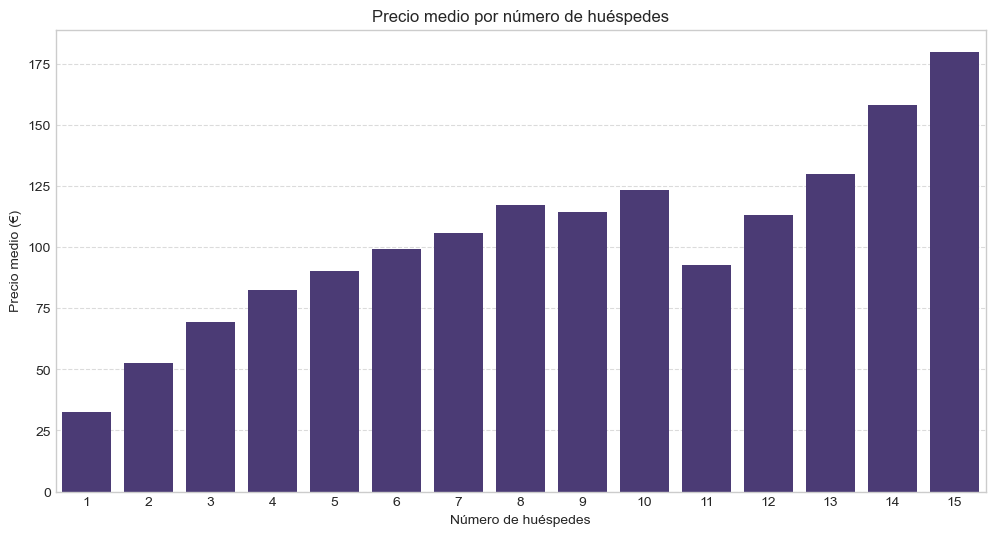

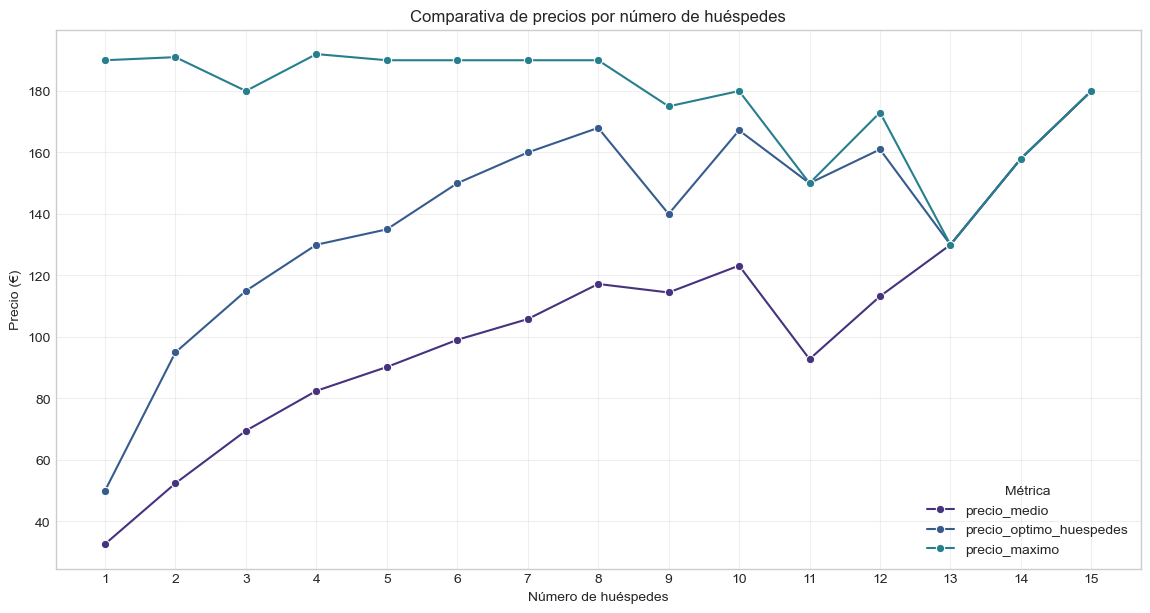

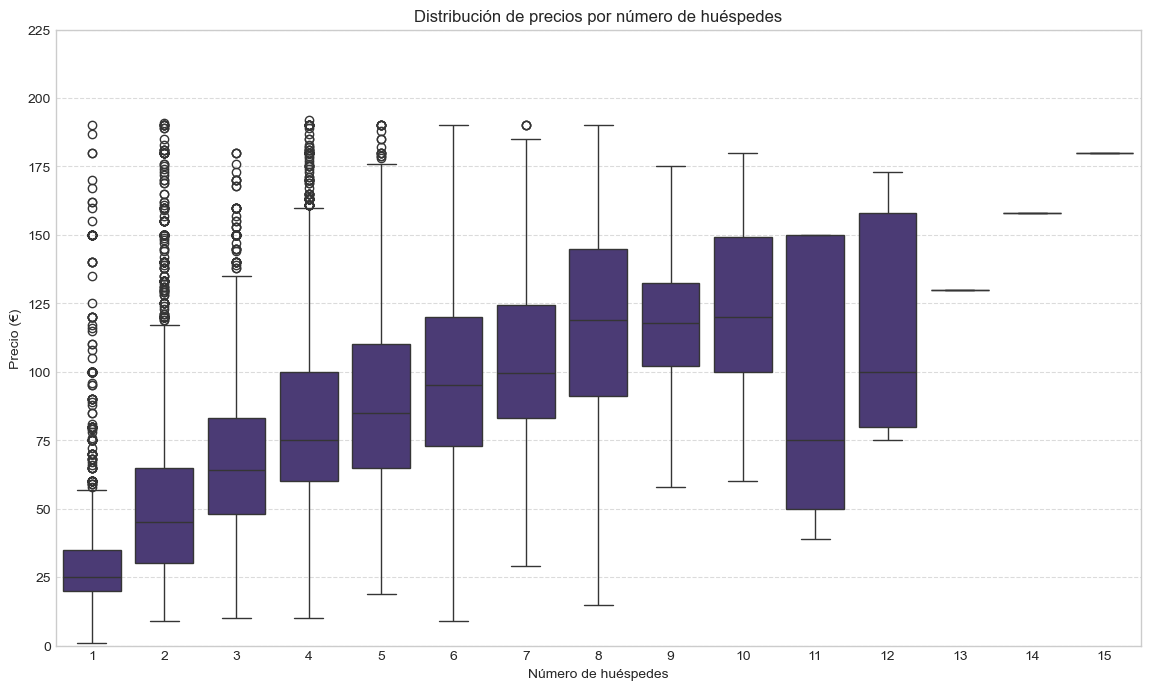

In [13]:
# Solo hay un apartamento con capacidad de 16 huéspedes y con un precio atípico de 15€. Lo eliminamos para que no distorsione los datos
df = df[df['accommodates']<16]

# Agrupar por número de huéspedes y calcular estadísticas
stats_por_huespedes = df.groupby('accommodates')['price'].agg([
    ('precio_medio', 'mean'),
    ('precio_optimo_huespedes', lambda x: np.percentile(x, 90)),
    ('precio_maximo', 'max'),
    ('count', 'count')  # Número de listings por grupo
]).reset_index()

# Redondear valores para mejor visualización
stats_por_huespedes = stats_por_huespedes.round(2)

# Mostrar las estadísticas
print("Estadísticas de precio por número de huéspedes:")
print(stats_por_huespedes)

precio_optimo_dict = dict(zip(stats_por_huespedes['accommodates'], 
                              stats_por_huespedes['precio_optimo_huespedes']))

# Crear la nueva columna 'precio_optimo_huespedes' 
df['precio_optimo_huespedes'] = df['accommodates'].map(precio_optimo_dict)

# Visualización: Gráfico de barras para precio medio por huéspedes
plt.figure(figsize=(12, 6))
sns.barplot(x='accommodates', y='precio_medio', data=stats_por_huespedes)
plt.title('Precio medio por número de huéspedes')
plt.xlabel('Número de huéspedes')
plt.ylabel('Precio medio (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualización: Gráfico comparativo de precios
plt.figure(figsize=(14, 7))

# Crear un DataFrame con formato adecuado para seaborn
plot_data = pd.melt(
    stats_por_huespedes, 
    id_vars=['accommodates'], 
    value_vars=['precio_medio', 'precio_optimo_huespedes', 'precio_maximo'],
    var_name='Métrica',
    value_name='Precio'
)

sns.lineplot(x='accommodates', y='Precio', hue='Métrica', data=plot_data, marker='o')
plt.title('Comparativa de precios por número de huéspedes')
plt.xlabel('Número de huéspedes')
plt.ylabel('Precio (€)')
plt.grid(True, alpha=0.3)
plt.xticks(stats_por_huespedes['accommodates'])
plt.show()

# Análisis adicional: Distribución de precios por número de huéspedes
plt.figure(figsize=(14, 8))
sns.boxplot(x='accommodates', y='price', data=df)
plt.title('Distribución de precios por número de huéspedes')
plt.xlabel('Número de huéspedes')
plt.ylabel('Precio (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, df['price'].quantile(0.95) * 1.5)  # Limitar el eje Y para mejor visualización
plt.show()

# 3. Análisis geográfico

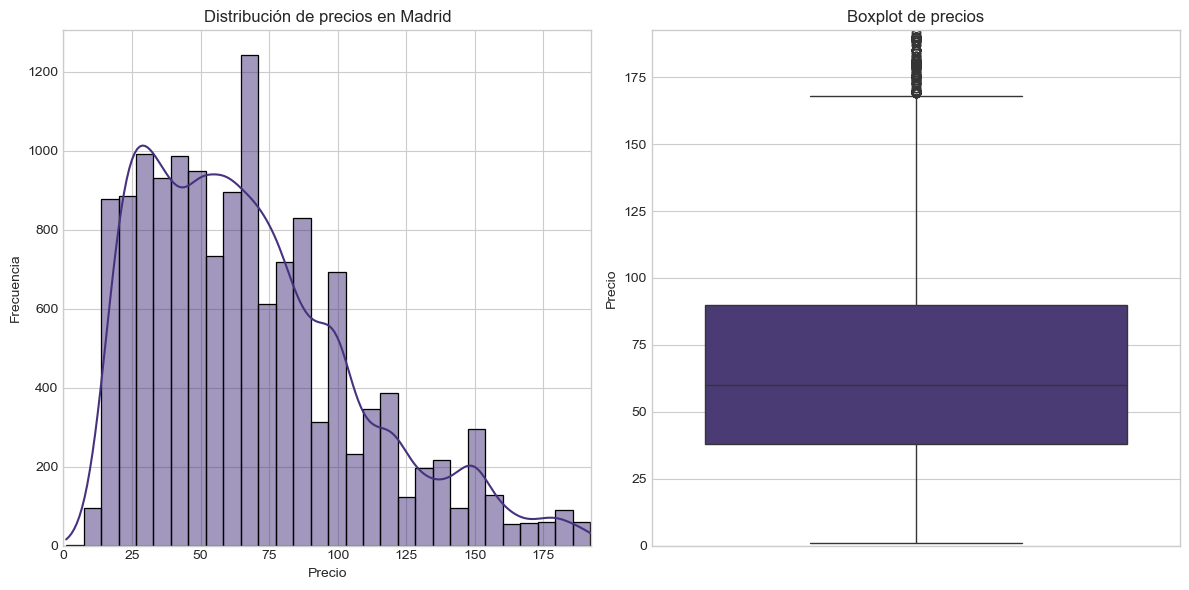

Estadísticas de precios en Madrid:
count    14084.000000
mean        67.972522
std         38.419213
min          1.000000
25%         38.000000
50%         60.000000
75%         90.000000
90%        120.000000
95%        150.000000
max        192.000000
Name: price, dtype: float64


In [14]:
# Análisis general de precios de la ciudad
plt.figure(figsize=(12, 6))

# Histograma y boxplot de precios
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribución de precios en Madrid')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.xlim(0, 192.50)  # Establecer límite en el eje x

plt.subplot(1, 2, 2)
sns.boxplot(y=df['price'])
plt.title('Boxplot de precios')
plt.ylabel('Precio')
plt.ylim(0, 192.50)  # Establecer límite en el eje y

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("Estadísticas de precios en Madrid:")
print(df['price'].describe(percentiles=[.25, .5, .75, .9, .95]))

## ¿Cómo influye en los precios la distancia a Sol?

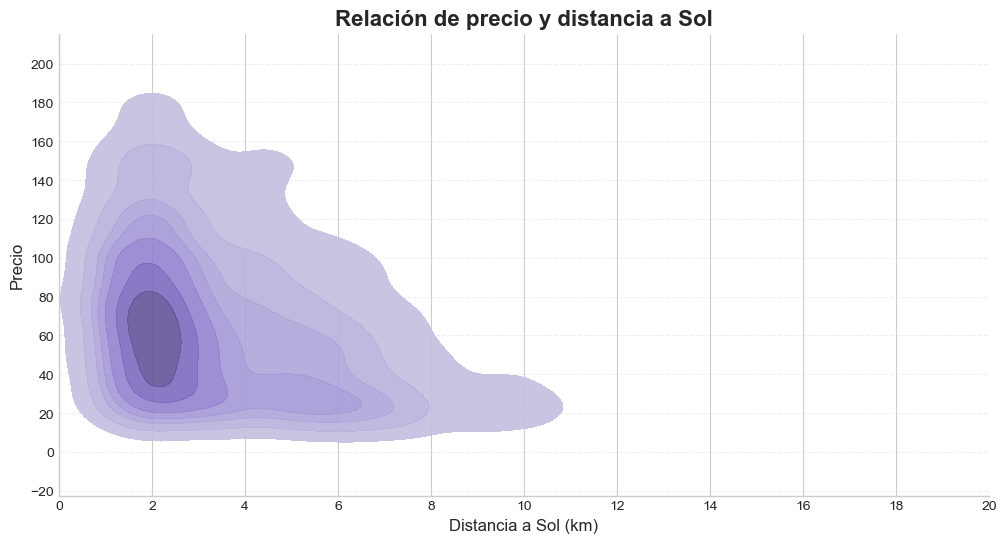

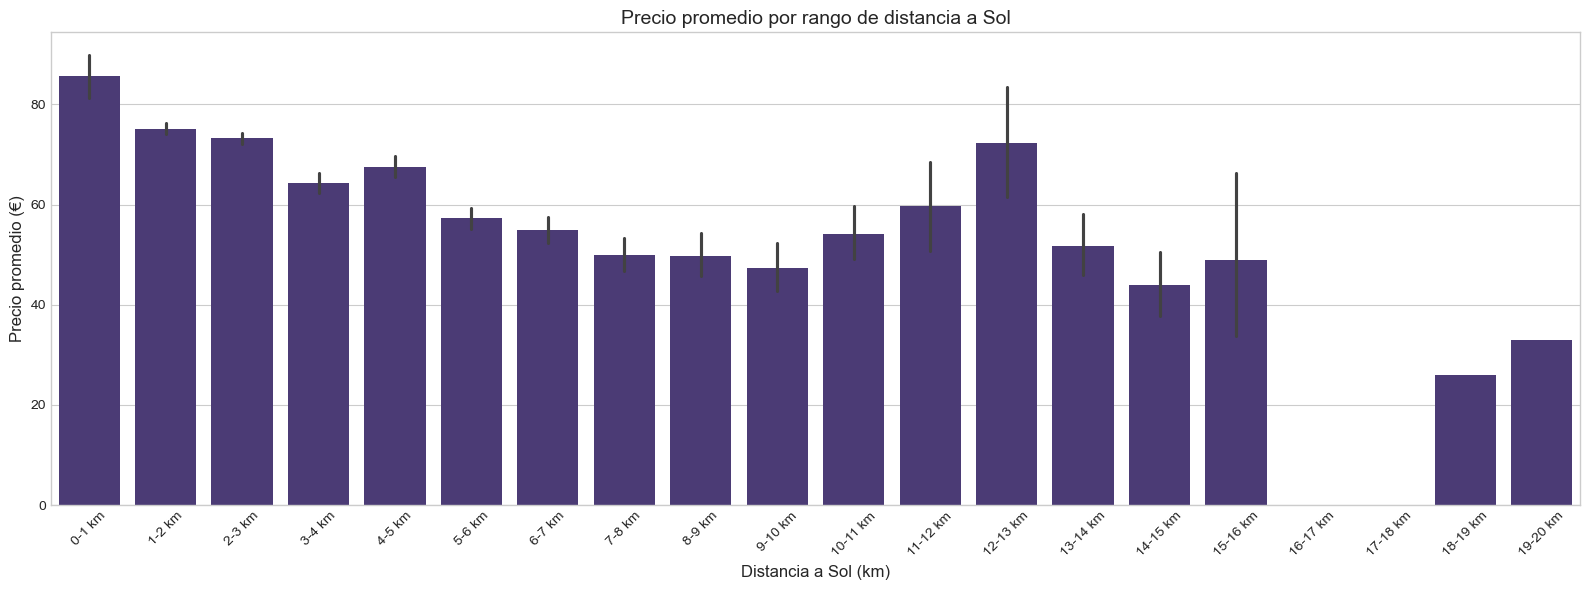

El precio medio en Madrid es: 67.97 €


,Distancia a Sol,Precio Medio (€),Comparación con Madrid
0,0-1 km,84.97,Mayor
1,1-2 km,75.16,Mayor
2,2-3 km,73.22,Mayor
3,3-4 km,64.26,Menor
4,4-5 km,67.53,Menor
5,5-6 km,57.28,Menor
6,6-7 km,54.92,Menor
7,7-8 km,49.89,Menor
8,8-9 km,49.83,Menor
9,9-10 km,47.43,Menor


In [15]:
# 1. Densidad de viviendas por precio VS distancia en km a Sol
plt.figure(figsize=(12, 6))

# 2D density plot de precio VS distancia en km a Sol
ax = sns.kdeplot(
    data=df,
    x="dist_km_sol",
    y="price",
    fill=True,
    alpha=0.9,
    thresh=0.1,
    levels=8
)

# Añadir título al plot y a los ejes
ax.set_title("Relación de precio y distancia a Sol", fontsize=16, fontweight="bold")
ax.set_xlabel("Distancia a Sol (km)", fontsize=12)  # Añadido "(km)" para claridad
ax.set_ylabel("Precio", fontsize=12)

# Personalizar el grid de fondo
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(20))
ax.grid(alpha=0.3, linestyle="--", axis="y")

# Limitar el eje X para consistencia
ax.set_xlim(0, 20)  # Limitado a 20 km igual que en la celda B

# Personalizar el marco del plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

# 2. Precio promedio por distancia a Sol (agrupado)
# Creamos categorías de distancia más granulares, especialmente después de los 10 km
df['dist_category'] = pd.cut(df['dist_km_sol'],
                           bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                           labels=['0-1 km', '1-2 km', '2-3 km', '3-4 km', '4-5 km', 
                                  '5-6 km', '6-7 km', '7-8 km', '8-9 km', '9-10 km',
                                  '10-11 km', '11-12 km', '12-13 km', '13-14 km', '14-15 km',
                                  '15-16 km', '16-17 km', '17-18 km', '18-19 km', '19-20 km'])

plt.figure(figsize=(16, 6))
sns.barplot(x='dist_category', y='price', data=df, estimator=np.mean)
plt.title('Precio promedio por rango de distancia a Sol', fontsize=14)
plt.xlabel('Distancia a Sol (km)', fontsize=12)  # Añadido "(km)" para claridad
plt.ylabel('Precio promedio (€)', fontsize=12)
plt.xticks(rotation=45)  # Rotar las etiquetas para mejor visualización
plt.tight_layout()
plt.show()

# Calcular el precio medio en Madrid
precio_medio_madrid = df["price"].mean()

# Definir los rangos de distancia en intervalos de 1 km
bins_km = np.arange(0, df["dist_km_sol"].max() + 1, 1)
distancias_km = [f"{int(bins_km[i])}-{int(bins_km[i+1])} km" for i in range(len(bins_km)-1)]

# Crear columna de clasificación por distancia
df["distancia_a_Sol"] = pd.cut(df["dist_km_sol"], bins=bins_km, labels=distancias_km, right=False)

# Calcular el precio medio por cada rango de distancia
precio_medio_km = df.groupby("distancia_a_Sol")["price"].mean().round(2).reset_index()
precio_medio_km.columns = ["Distancia a Sol", "Precio Medio (€)"]

# Comparar con la media de Madrid
precio_medio_km["Comparación con Madrid"] = precio_medio_km["Precio Medio (€)"].apply(
    lambda x: "Mayor" if x > precio_medio_madrid else "Menor" if x < precio_medio_madrid else "Igual"
)

# Eliminar valores NaN
precio_medio_km = precio_medio_km.dropna()

print(f"El precio medio en Madrid es: {precio_medio_madrid:.2f} €")
# Mostrar la nueva tabla
precio_medio_km

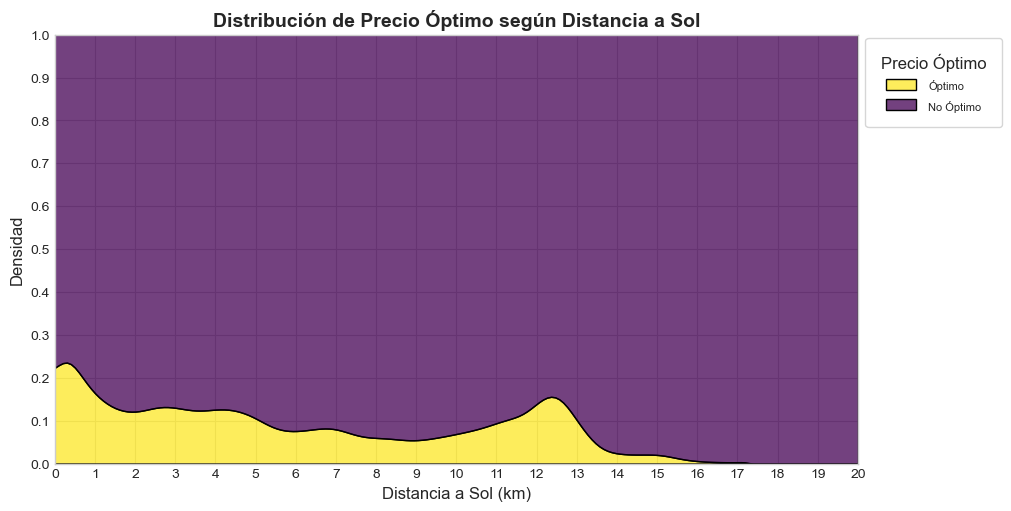

Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes rangos de distancia:
- 2-3 km: 30.80% del total
- 1-2 km: 29.55% del total
- 4-5 km: 10.05% del total


,Distancia a Sol,% Distribución Óptimos
0,0-1 km,4.61%
1,1-2 km,29.55%
2,2-3 km,30.8%
3,3-4 km,9.87%
4,4-5 km,10.05%
5,5-6 km,5.32%
6,6-7 km,4.55%
7,7-8 km,1.44%
8,8-9 km,0.84%
9,9-10 km,0.84%


In [16]:
# Crear figura
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Paleta personalizada
paleta_personalizada = ["#440154", "#FDE725"]

# Gráfico KDE con ajuste de suavidad y evitando valores negativos
sns.kdeplot(
    data=df,
    x="dist_km_sol",
    hue="precio_optimo",
    multiple="fill",
    palette=paleta_personalizada,
    ax=ax,
    clip=(0, 20) 
)

# Títulos y etiquetas
ax.set_title("Distribución de Precio Óptimo según Distancia a Sol", fontsize=14, fontweight="bold")
ax.set_xlabel("Distancia a Sol (km)", fontsize=12) 
ax.set_ylabel("Densidad", fontsize=12)

# Ajustar el eje X para que use intervalos de 1 km
ax.set_xticks(np.arange(0, df["dist_km_sol"].max() + 1, 1))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Asegurar que el eje X comienza exactamente en 0 y termina en 20 para consistencia
ax.set_xlim(0, 20)

# Leyenda
leg = ax.legend(
    title="Precio Óptimo",
    labels=["Óptimo", "No Óptimo"],
    title_fontsize=12,
    fontsize=11,
    loc="upper left",
    bbox_to_anchor=(1, 1.01),
    frameon=True,
    borderpad=1,
)

# Tamaño fuente leyenda
for text in leg.get_texts():
    text.set_fontsize(8)

# Mostrar gráfico
plt.show()

# Calcular el porcentaje de pisos con precio óptimo por rango de distancia
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("distancia_a_Sol")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("distancia_a_Sol")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Calcular el porcentaje de pisos con precio óptimo por rango de distancia
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("distancia_a_Sol")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_precios = distribucion_optimos.reset_index()
distribucion_precios.columns = ["Distancia a Sol", "% Distribución Óptimos"]
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].round(2)  
distribucion_precios = distribucion_precios[distribucion_precios["% Distribución Óptimos"] > 0]

# Identificar las distancias con mayor concentración de pisos óptimos
top_rangos = distribucion_precios.sort_values(by="% Distribución Óptimos", ascending=False).head(3)

# Imprimir el comentario sobre la concentración
print("Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes rangos de distancia:")
for _, row in top_rangos.iterrows():
    print(f"- {row['Distancia a Sol']}: {row['% Distribución Óptimos']:.2f}% del total")

# Ahora convertir a string con % para mostrar en la tabla
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].apply(lambda x: f"{x}%")

# Mostrar la tabla
distribucion_precios

Tabla completa de viviendas por distancia y capacidad:
accommodates      1     2    3     4    5    6   7    8   9   10  11  12  13  \
distancia_a_Sol                                                                
0-1 km            19    93   34   118   28   62   5   12   1   2   1   1   0   
1-2 km           229  1092  358  1150  213  468  56  110   8  12   1   6   1   
2-3 km           355  1228  399  1111  200  376  49   61   3   9   2   1   0   
3-4 km           276   496  130   353   93  123  16   14   0   1   0   0   0   
4-5 km           206   415  125   309   87  120  12   15   0   2   0   0   0   
5-6 km           230   422   82   245   54  109  10   17   2   2   1   0   0   
6-7 km           205   300   56   174   38   59   6    7   0   0   0   0   0   
7-8 km           142   135   38    87   11   36   0    8   0   0   0   0   0   
8-9 km            62    86   22    45   12   12   2    3   0   0   0   0   0   
9-10 km           89    68   21    33   10   14   1    0   0   0 

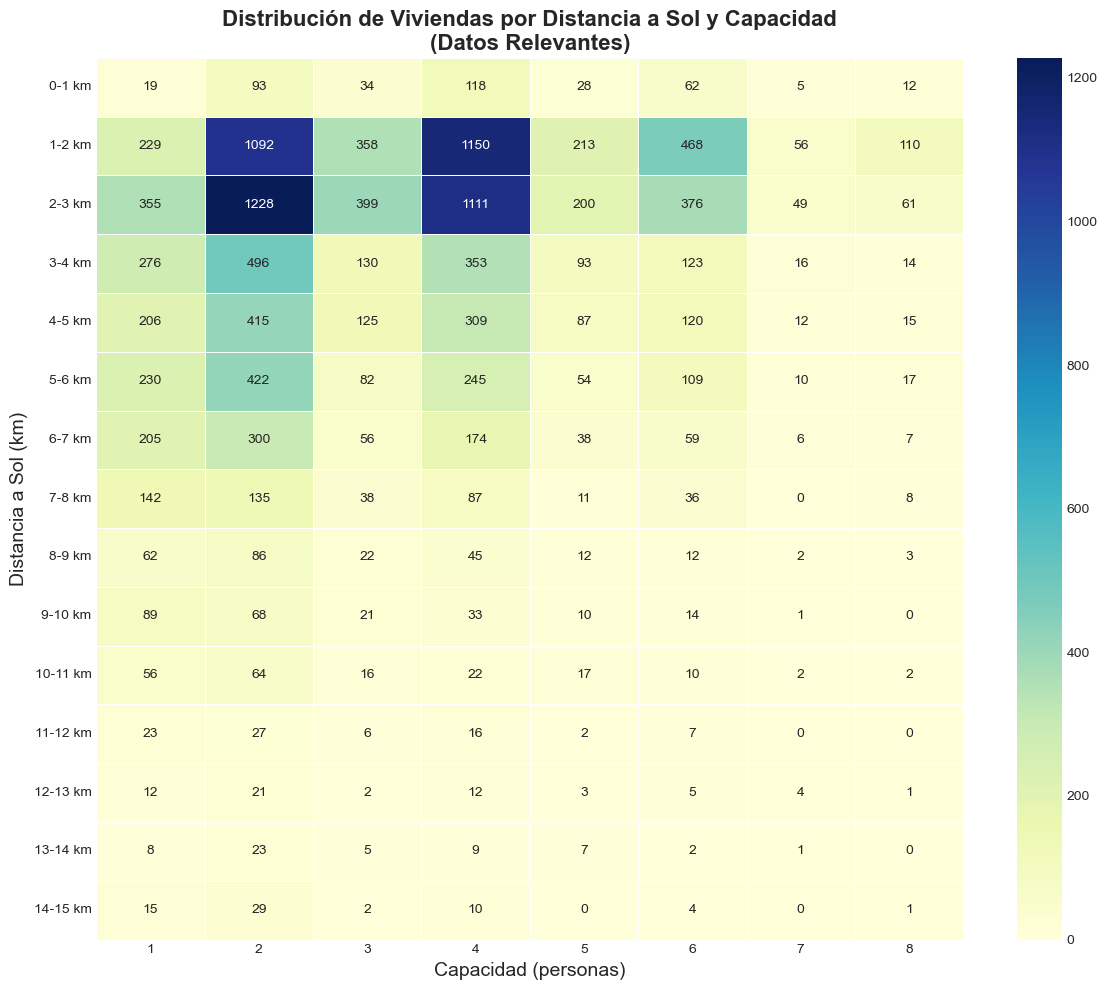


El heatmap muestra 14013 viviendas (99.5% del total)
Se excluyeron 71 viviendas (0.5% del total)


In [17]:
# Crear la tabla cruzada de conteo sin filtrados iniciales
tabla_conteo = pd.pivot_table(df,
                               index='distancia_a_Sol',
                               columns='accommodates',
                               values='precio_optimo',
                               aggfunc='count',
                               fill_value=0)

# Mostrar la tabla completa para examinarla
print("Tabla completa de viviendas por distancia y capacidad:")
print(tabla_conteo)

# Calcular el número total de viviendas
total_viviendas = tabla_conteo.sum().sum()
print(f"\nTotal de viviendas: {total_viviendas}")

# Calcular porcentajes por fila y columna
porcentaje_filas = (tabla_conteo.sum(axis=1) / total_viviendas * 100).round(1)
porcentaje_columnas = (tabla_conteo.sum(axis=0) / total_viviendas * 100).round(1)

print("\nPorcentaje de viviendas por distancia:")
for idx, valor in porcentaje_filas.items():
    print(f"Distancia {idx} km: {valor}% ({tabla_conteo.sum(axis=1)[idx]} viviendas)")

print("\nPorcentaje de viviendas por capacidad:")
for idx, valor in porcentaje_columnas.items():
    print(f"Capacidad {idx} personas: {valor}% ({tabla_conteo.sum(axis=0)[idx]} viviendas)")

# Basado en los datos proporcionados, ajustar umbrales adecuados
umbral_viviendas = 0  # No eliminar celdas por número de viviendas
umbral_porcentaje_fila = 0.4  # Mantener distancias de 0-15 km (0.4% cubre hasta 14-15 km)
umbral_porcentaje_columna = 1.0  # Aumentar a 1% para eliminar columnas con pocas viviendas

# Filtrar filas y columnas según umbrales
filas_a_mantener = porcentaje_filas[porcentaje_filas >= umbral_porcentaje_fila].index
columnas_a_mantener = porcentaje_columnas[porcentaje_columnas >= umbral_porcentaje_columna].index

tabla_filtrada = tabla_conteo.loc[filas_a_mantener, columnas_a_mantener]

# Crear el heatmap optimizado
plt.figure(figsize=(12, 10))
ax = sns.heatmap(tabla_filtrada, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)

# Mejorar la presentación
plt.title('Distribución de Viviendas por Distancia a Sol y Capacidad\n(Datos Relevantes)', fontsize=16, fontweight='bold')
plt.ylabel('Distancia a Sol (km)', fontsize=14)
plt.xlabel('Capacidad (personas)', fontsize=14)

# Ajustar etiquetas para mayor claridad
plt.tight_layout()
plt.show()

# Mostrar resumen de datos incluidos vs excluidos
viviendas_incluidas = tabla_filtrada.sum().sum()
porcentaje_incluido = (viviendas_incluidas / total_viviendas) * 100
print(f"\nEl heatmap muestra {viviendas_incluidas} viviendas ({porcentaje_incluido:.1f}% del total)")
print(f"Se excluyeron {total_viviendas - viviendas_incluidas} viviendas ({100 - porcentaje_incluido:.1f}% del total)")

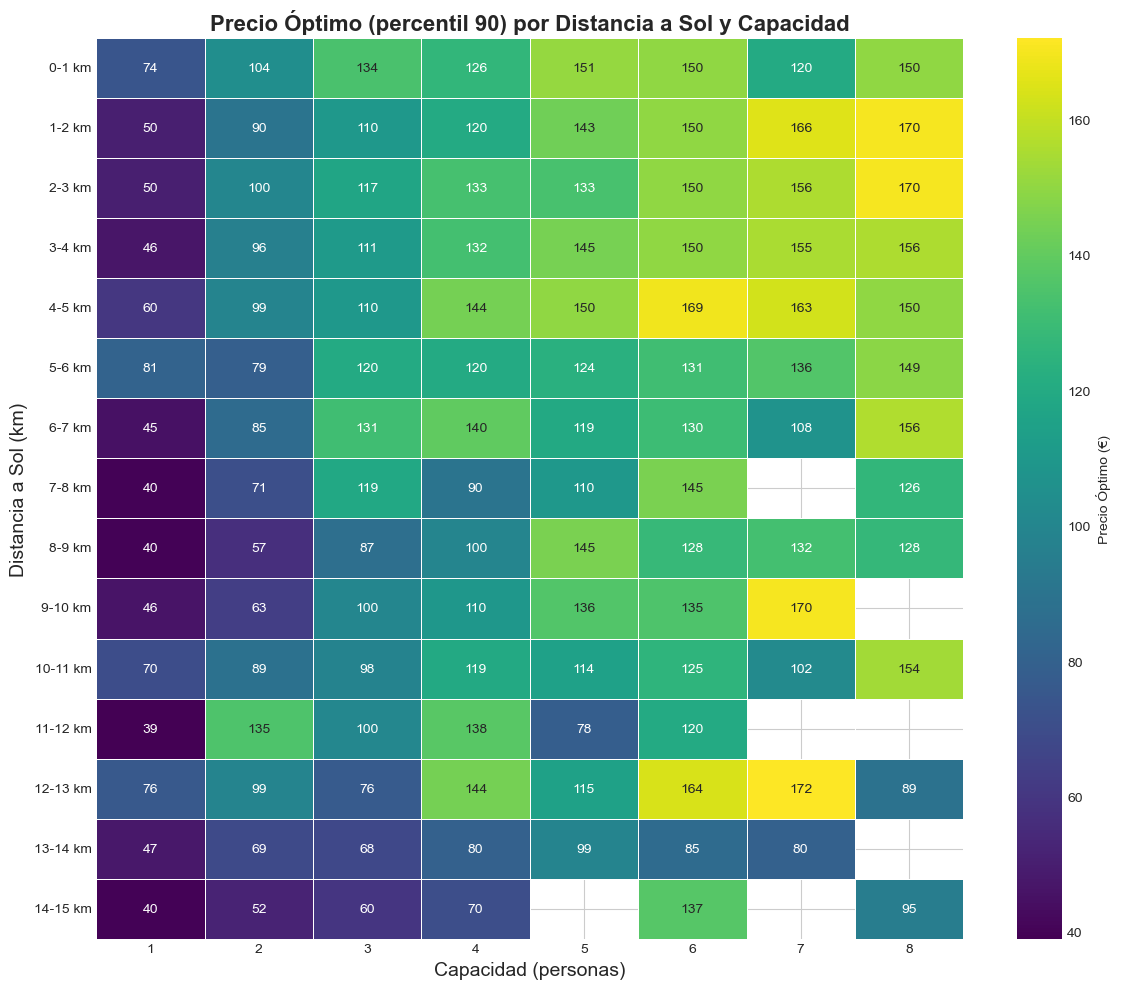


Tabla de Precios Óptimos Máximos por Capacidad:
          Distancia con precio máximo  Precio Óptimo máximo (€)
Capacidad                                                      
1                              5-6 km                      80.9
2                            11-12 km                     135.0
3                              0-1 km                     134.0
4                              4-5 km                     144.2
5                              0-1 km                     151.2
6                              4-5 km                     169.1
7                            12-13 km                     172.0
8                              1-2 km                     170.0


In [18]:
# Crear tabla cruzada con el percentil 90 del precio por grupo
tabla_precios = pd.pivot_table(df,
                               index='distancia_a_Sol',
                               columns='accommodates',
                               values='price',
                               aggfunc=lambda x: np.percentile(x, 90),  # Usar percentil 90
                               fill_value=np.nan)  # Usar NaN para valores vacíos

# Basado en los datos proporcionados anteriormente, ajustar umbrales adecuados
umbral_porcentaje_fila = 0.4  # Mantener distancias de 0-15 km (0.4% cubre hasta 14-15 km)
umbral_porcentaje_columna = 1.0  # Mantener capacidades que representen al menos 1% del total

# Calcular porcentajes por fila y columna (reutilizando los cálculos anteriores)
porcentaje_filas = (tabla_conteo.sum(axis=1) / total_viviendas * 100).round(1)
porcentaje_columnas = (tabla_conteo.sum(axis=0) / total_viviendas * 100).round(1)

# Filtrar filas y columnas según umbrales
filas_a_mantener = porcentaje_filas[porcentaje_filas >= umbral_porcentaje_fila].index
columnas_a_mantener = porcentaje_columnas[porcentaje_columnas >= umbral_porcentaje_columna].index

tabla_filtrada_precios = tabla_precios.loc[filas_a_mantener, columnas_a_mantener]

# Crear el heatmap de precios óptimos con viridis
plt.figure(figsize=(12, 10))
ax = sns.heatmap(tabla_filtrada_precios, annot=True, fmt='.0f', cmap='viridis', linewidths=0.5, 
                cbar_kws={'label': 'Precio Óptimo (€)'})

# Mejorar la presentación
plt.title('Precio Óptimo (percentil 90) por Distancia a Sol y Capacidad', 
          fontsize=16, fontweight='bold')
plt.ylabel('Distancia a Sol (km)', fontsize=14)
plt.xlabel('Capacidad (personas)', fontsize=14)

# Ajustar etiquetas para mayor claridad
plt.tight_layout()
plt.show()

# Crear tabla que muestre dónde está el precio óptimo más alto para cada capacidad
# Encontrar en qué distancia está el precio óptimo más alto para cada capacidad
precios_max_por_capacidad = {}
distancias_max_por_capacidad = {}

for capacidad in columnas_a_mantener:
    if capacidad in tabla_filtrada_precios.columns:
        # Encontrar la distancia con el precio máximo para esta capacidad
        idx_max = tabla_filtrada_precios[capacidad].idxmax()
        precio_max = tabla_filtrada_precios.loc[idx_max, capacidad]
        
        precios_max_por_capacidad[capacidad] = precio_max
        distancias_max_por_capacidad[capacidad] = idx_max

# Crear DataFrame para mostrar la tabla
tabla_precios_maximos = pd.DataFrame({
    'Capacidad': list(precios_max_por_capacidad.keys()),
    'Distancia con precio máximo': list(distancias_max_por_capacidad.values()),
    'Precio Óptimo máximo (€)': list(precios_max_por_capacidad.values())
})

# Establecer Capacidad como índice
tabla_precios_maximos = tabla_precios_maximos.set_index('Capacidad')
tabla_precios_maximos = tabla_precios_maximos.sort_index()

# Mostrar la tabla
print("\nTabla de Precios Óptimos Máximos por Capacidad:")
print(tabla_precios_maximos)

## ¿Cómo varía el precio según el barrio?

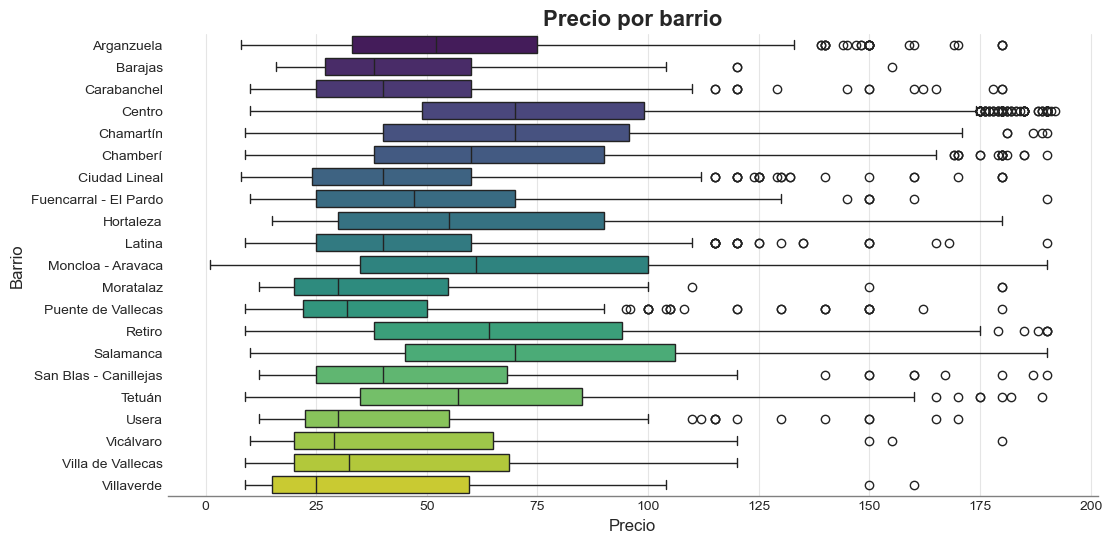

In [19]:
# configurar tamaño del plot
plt.figure(figsize=(12, 6))
# boxplot precio por barrio
ax = sns.boxplot(
    data=df.sort_values("neighbourhood_group"),
    x="price",
    y="neighbourhood_group",
    hue="neighbourhood_group", 
    palette= "viridis"
)
# añadir título al plot y a los ejes
ax.set_title("Precio por barrio", fontsize=16, fontweight="bold")
ax.set_xlabel("Precio", fontsize=12)
ax.set_ylabel("Barrio", fontsize=12)
# personalizar el grid de fondo
ax.grid(alpha=0.5, drawstyle="steps", axis="x", linestyle="-")
# personalizar el marco del plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("gray")
# show plot
plt.show()

                       price                                            \
                        mean precio_median_barrio precio_optimo_barrio   
neighbourhood_group                                                      
Salamanca              79.23                 70.0                150.0   
Moncloa - Aravaca      74.09                 61.0                147.0   
Hortaleza              64.92                 55.0                135.0   
Chamartín              73.21                 70.0                130.0   
Centro                 75.59                 70.0                128.0   
Vicálvaro              51.31                 29.0                126.0   
Retiro                 69.24                 64.0                125.0   
Chamberí               68.02                 60.0                120.0   
Tetuán                 64.71                 57.0                120.0   
San Blas - Canillejas  52.02                 40.0                100.0   
Arganzuela             57.81          

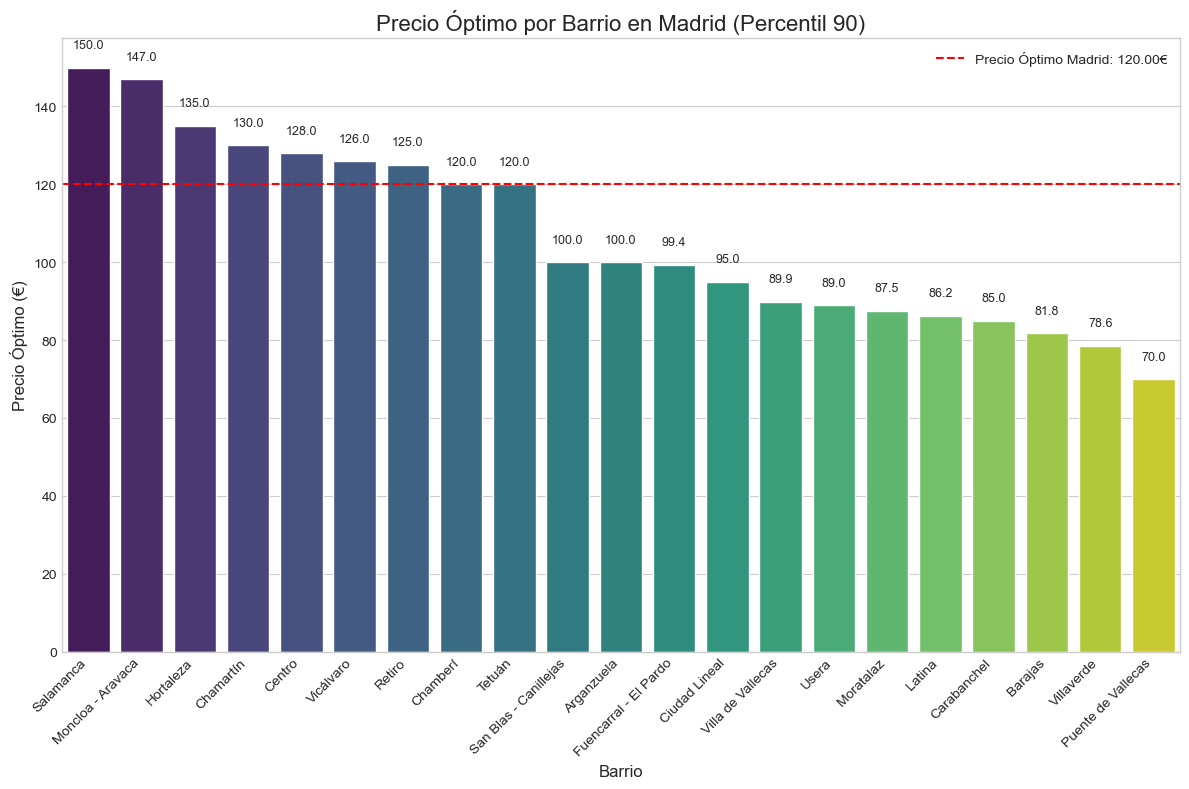

Barrios con precio óptimo por encima del precio óptimo de Madrid:
Salamanca, Moncloa - Aravaca, Hortaleza, Chamartín, Centro, Vicálvaro, Retiro


In [20]:
# Definir precios
def precio_optimo_barrio(val):
    return val.quantile(0.90)

def precio_median_barrio(val):
    return val.median()
df_barrio_statistics = df.groupby("neighbourhood_group").agg({
    "price": [("mean", lambda x: x.mean().round(2)),  
              ("precio_median_barrio", precio_median_barrio), 
              ("precio_optimo_barrio", precio_optimo_barrio)],
    "dist_km_sol": [("dist_min", lambda x: round(x.min(), 1)),  
                    ("dist_max", lambda x: round(x.max(), 1))]
}).sort_values(("price", "precio_optimo_barrio"), ascending=False)

print(df_barrio_statistics)

# Configuramos el tamaño y estilo del gráfico
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Extraemos directamente los datos para el gráfico
barrios = df_barrio_statistics.index
precios_optimos = df_barrio_statistics[('price', 'precio_optimo_barrio')]

# Creamos el gráfico de barras
ax = sns.barplot(x=barrios, y=precios_optimos, palette="viridis")

# Añadimos la línea de referencia para el precio óptimo de Madrid
plt.axhline(y=umbral_precio_optimo, color='r', linestyle='--', 
            label=f'Precio Óptimo Madrid: {umbral_precio_optimo:.2f}€')

# Configuramos el gráfico
plt.title('Precio Óptimo por Barrio en Madrid (Percentil 90)', fontsize=16)
plt.xlabel('Barrio', fontsize=12)
plt.ylabel('Precio Óptimo (€)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()

# Añadimos los valores en las barras
for i, v in enumerate(precios_optimos):
    ax.text(i, v + 5, f'{v:.1f}', ha='center', fontsize=9)

plt.show()

# Mostramos qué barrios están por encima del precio óptimo de Madrid
print("Barrios con precio óptimo por encima del precio óptimo de Madrid:")
barrios_sobre_media = df_barrio_statistics[df_barrio_statistics[('price', 'precio_optimo_barrio')] > umbral_precio_optimo].index.tolist()
print(", ".join(barrios_sobre_media))


# 4. Análisis inmueble

## ¿Qué características tienen los pisos con precios óptimos

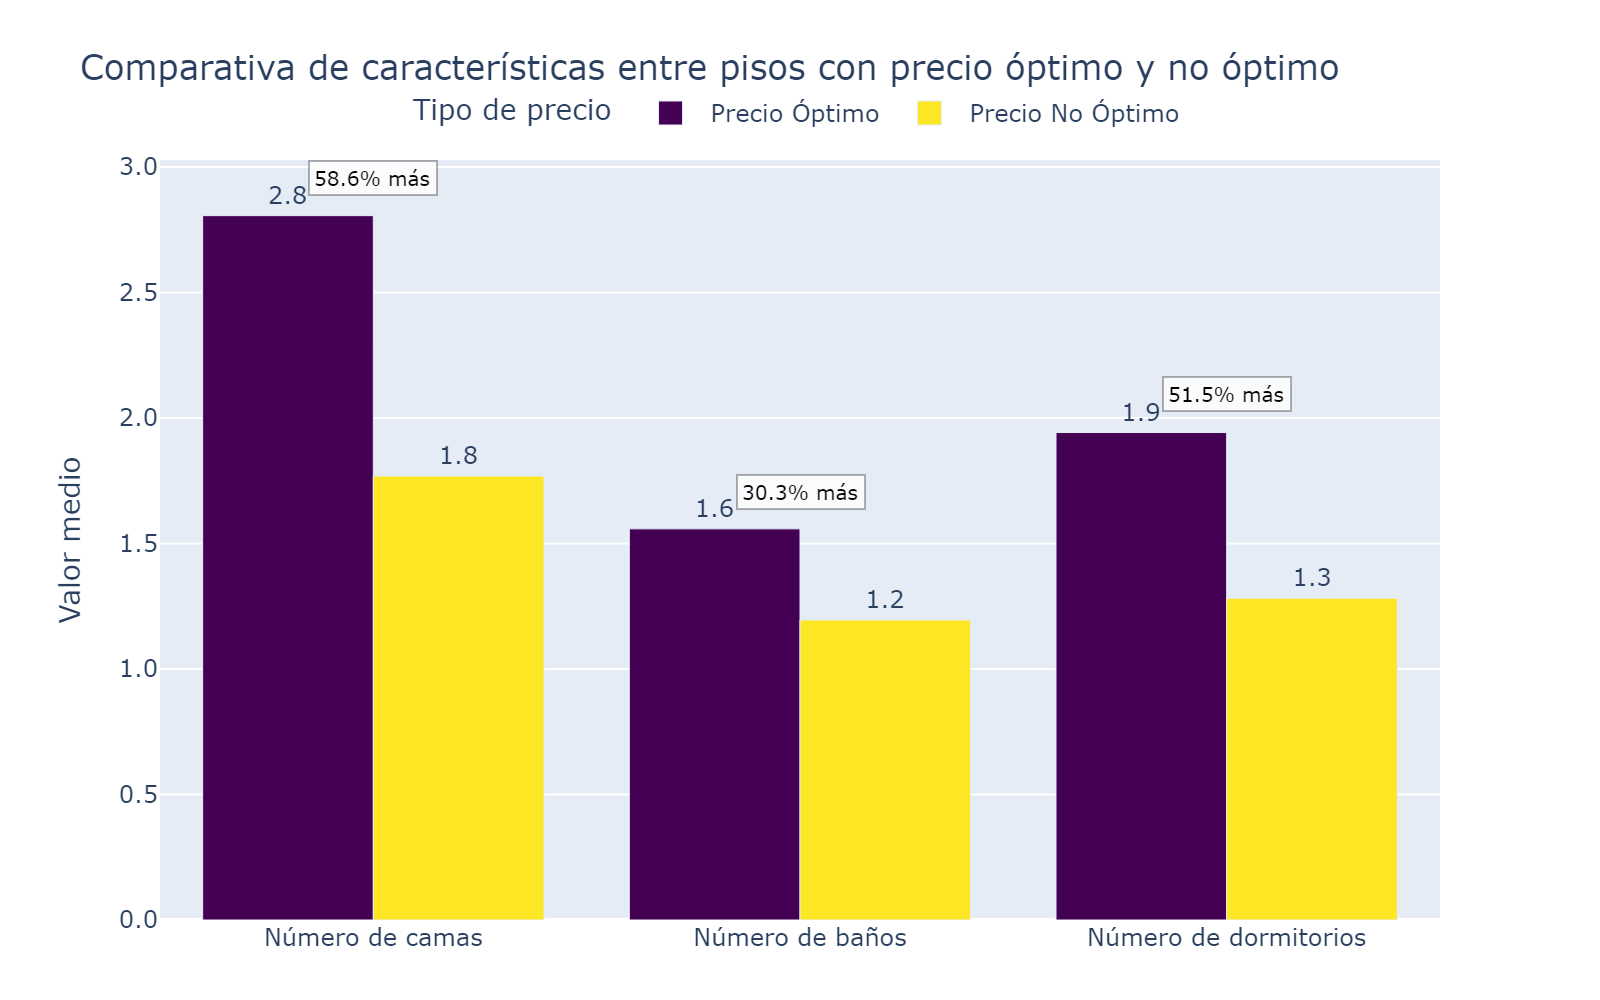

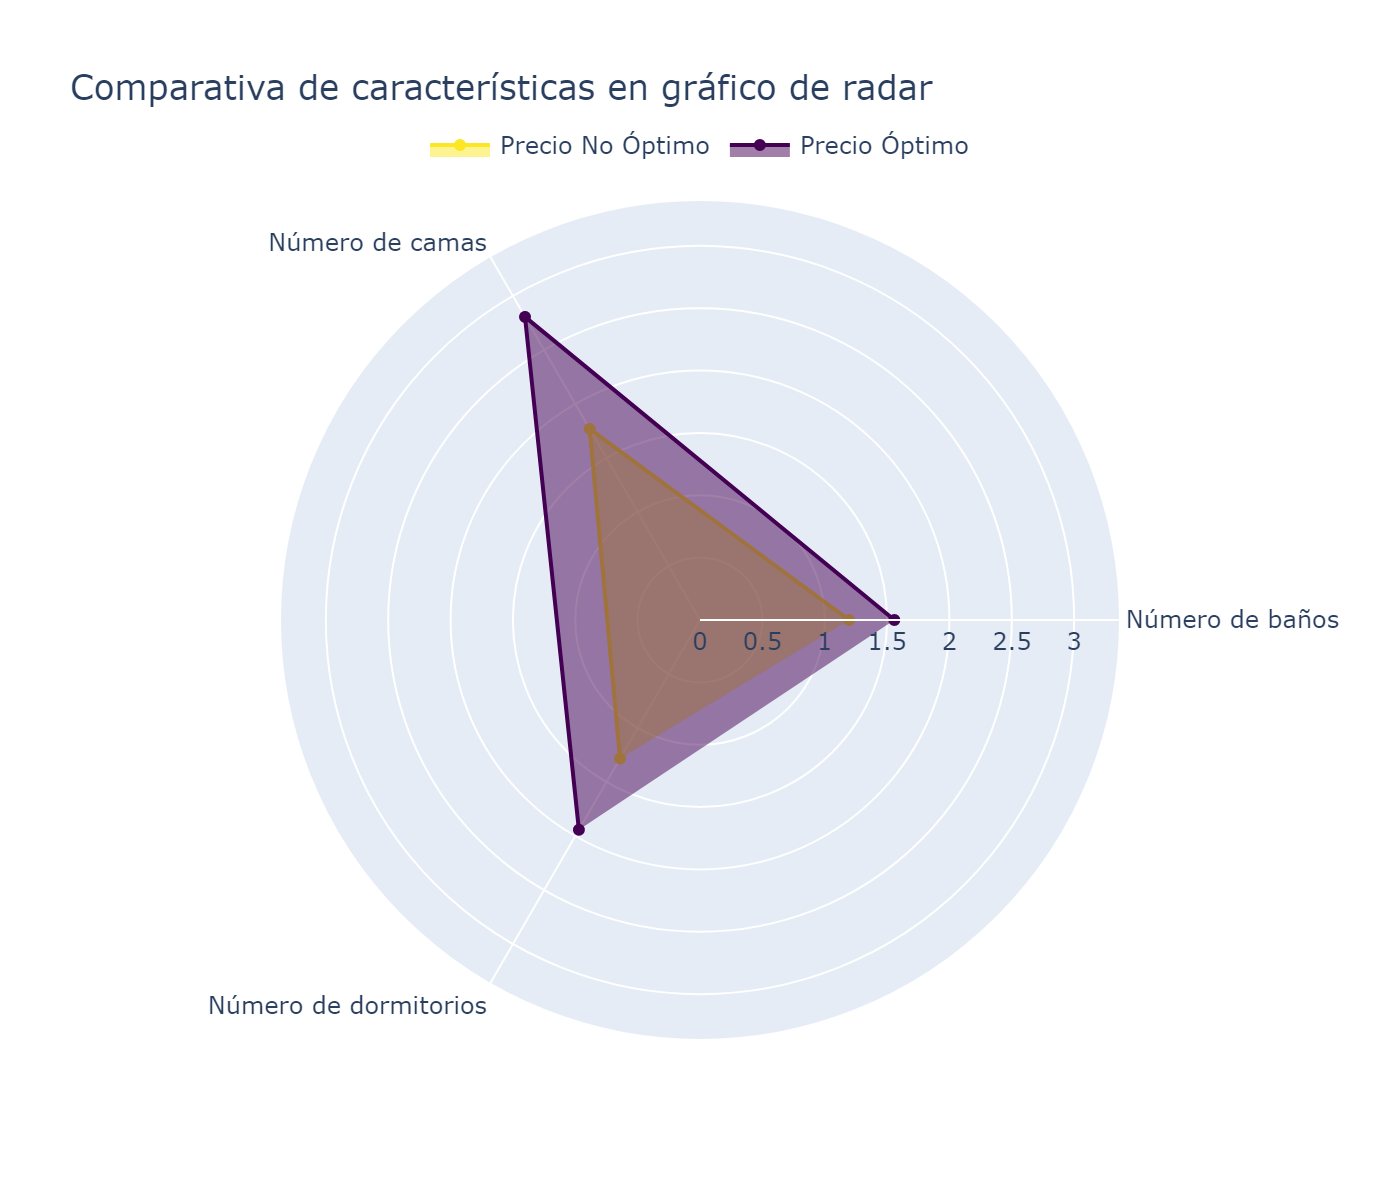

In [21]:
variables = ["beds", "bathrooms", "bedrooms"]
stats_df = pd.DataFrame()

for var in variables:
    media_optimo = df[df["precio_optimo"] == True][var].mean()
    media_no_optimo = df[df["precio_optimo"] == False][var].mean()
    
    stats_df = pd.concat([stats_df, pd.DataFrame({
        'variable': [var, var],
        'grupo': ['Precio Óptimo', 'Precio No Óptimo'],
        'valor_medio': [media_optimo, media_no_optimo]
    })])

nombre_variables = {
    "beds": "Número de camas",
    "bathrooms": "Número de baños",
    "bedrooms": "Número de dormitorios"
}

stats_df['variable_nombre'] = stats_df['variable'].map(nombre_variables)

fig = px.bar(
    stats_df, 
    x='variable_nombre', 
    y='valor_medio', 
    color='grupo',
    barmode='group',
    title='Comparativa de características entre pisos con precio óptimo y no óptimo',
    labels={'valor_medio': 'Valor medio', 'variable_nombre': 'Característica', 'grupo': 'Tipo de precio'},
    color_discrete_map={'Precio Óptimo': '#440154', 'Precio No Óptimo': '#FDE725'}
)

fig.update_traces(texttemplate='%{y:.1f}', textposition='outside')

fig.update_layout(
    legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='center', x=0.5),
    yaxis=dict(title='Valor medio', tickformat='.1f'),
    xaxis=dict(title=None),
    margin=dict(t=80, b=40),
    height=500,
    width=800
)

for var in nombre_variables.values():
    subset = stats_df[stats_df['variable_nombre'] == var]
    valor_optimo = subset[subset['grupo'] == 'Precio Óptimo']['valor_medio'].values[0]
    valor_no_optimo = subset[subset['grupo'] == 'Precio No Óptimo']['valor_medio'].values[0]
    
    if valor_no_optimo > 0:
        pct_diff = ((valor_optimo - valor_no_optimo) / valor_no_optimo) * 100
        direccion = "más" if pct_diff > 0 else "menos"
        
        fig.add_annotation(
            x=var,
            y=max(valor_optimo, valor_no_optimo) + 0.15,
            text=f"{abs(pct_diff):.1f}% {direccion}",
            showarrow=False,
            font=dict(size=10, color="black"),
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="rgba(0, 0, 0, 0.3)",
            borderwidth=1,
            borderpad=2
        )

fig.show()

radar_df = stats_df.pivot(index='grupo', columns='variable_nombre', values='valor_medio').reset_index()

fig_radar = go.Figure()

for i, grupo in enumerate(radar_df['grupo']):
    fig_radar.add_trace(go.Scatterpolar(
        r=radar_df.iloc[i, 1:].values.tolist(),
        theta=radar_df.columns[1:].tolist(),
        fill='toself',
        name=grupo,
        line_color='#440154' if grupo == 'Precio Óptimo' else '#FDE725'
    ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, stats_df['valor_medio'].max() * 1.2]
        )
    ),
    title='Comparativa de características en gráfico de radar',
    showlegend=True,
    legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='center', x=0.5),
    height=600,
    width=700
)

fig_radar.show()

# fig.write_image("../docs/comparativa_camas_baños_dormitorios_precio.png", scale=2)
# fig_radar.write_image("../docs/comparativa_camas_baños_dormitorios_precio_radar.png", scale=2)
display(Image(filename="../docs/comparativa_camas_baños_dormitorios_precio.png"))
display(Image(filename="../docs/comparativa_camas_baños_dormitorios_precio_radar.png"))



## ¿Qué comodidades tienen los pisos con precio óptimo?

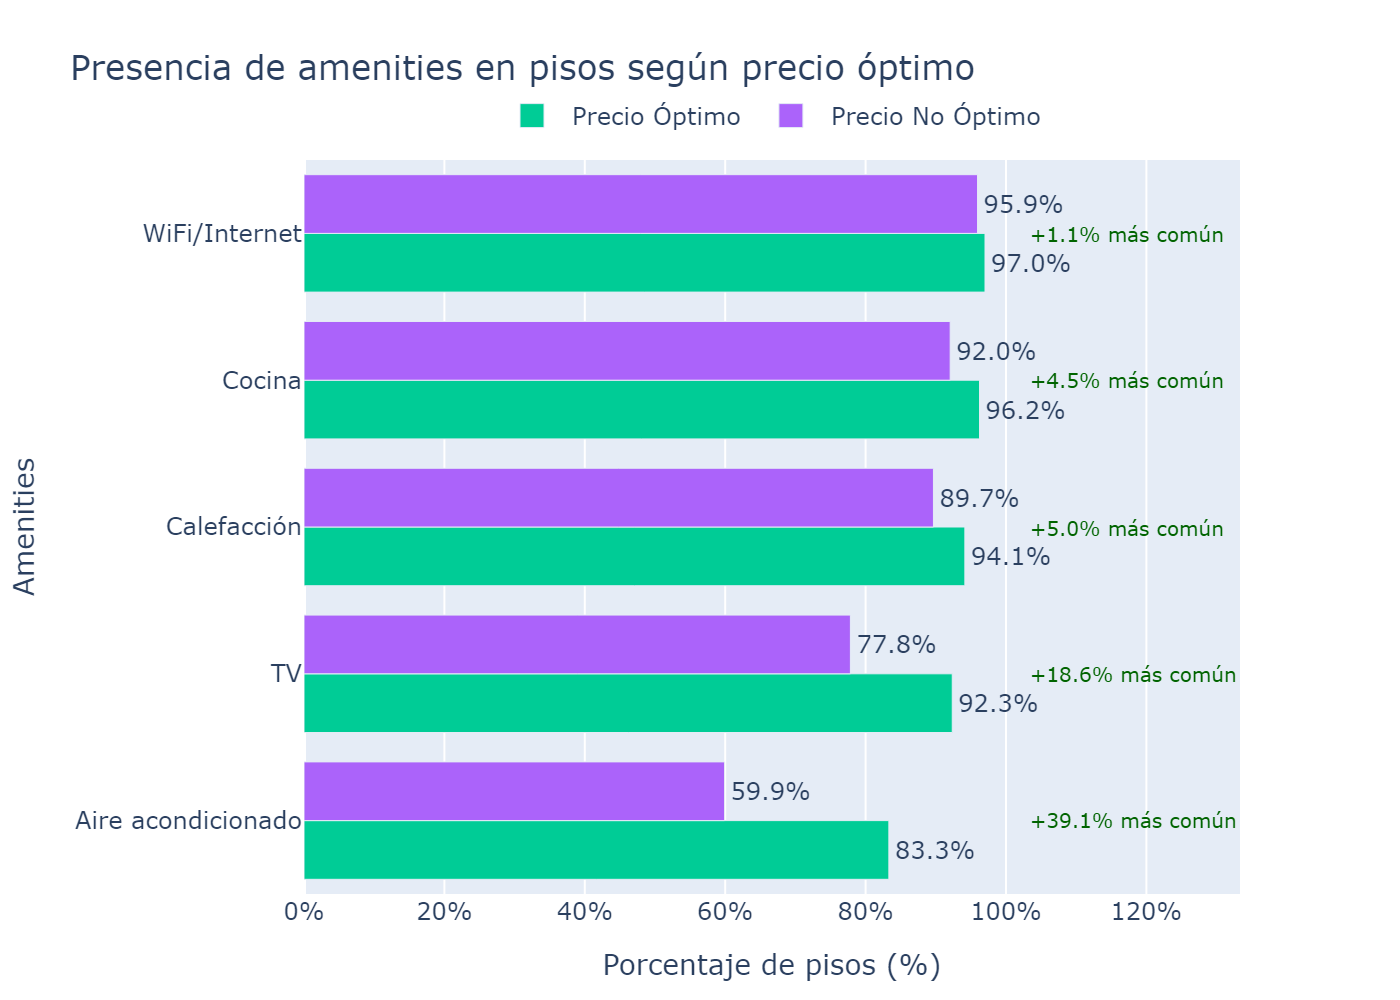

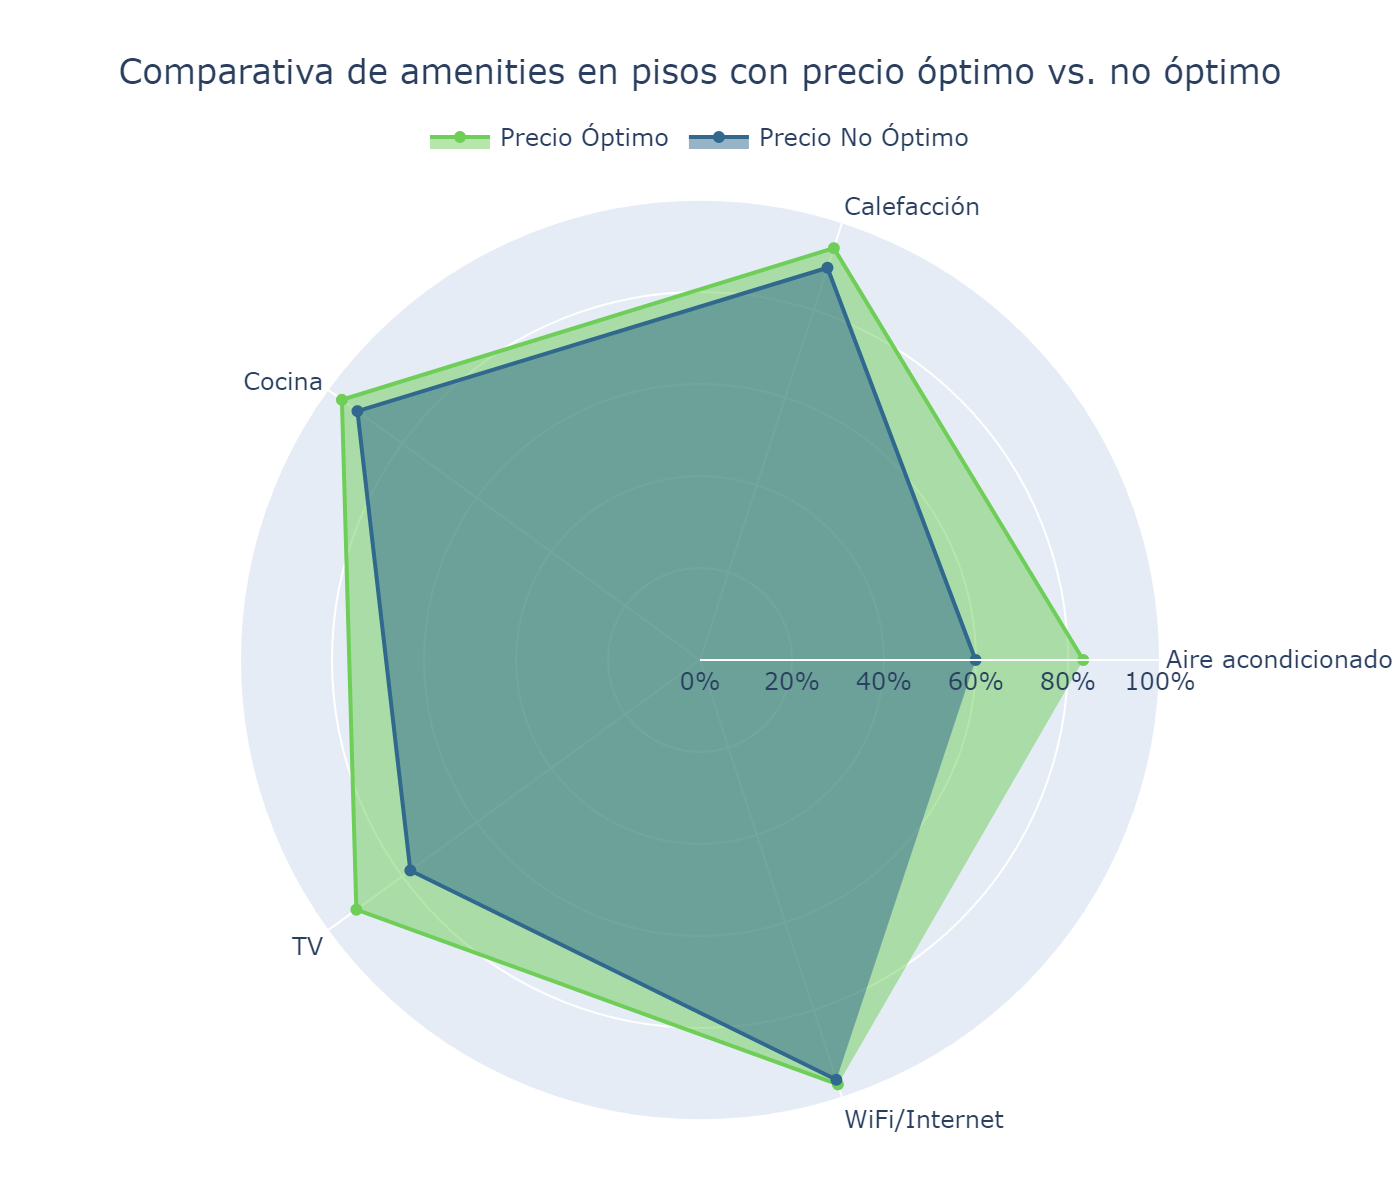

In [22]:
# Calcular el porcentaje de pisos según los amenities
amenities = ["amenities_wifi_internet", "amenities_tv", "amenities_air_conditioning", "amenities_heating", "amenities_kitchen"]
df_property_lux = df[["precio_optimo"] + amenities].groupby("precio_optimo", as_index=False).mean()

# Transformar los datos para la visualización
df_property_lux = (
    df_property_lux
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "amenities", "value": "porcentaje"})
)

# Mejorar los nombres de los amenities para la visualización
nombre_amenities = {
    "amenities_wifi_internet": "WiFi/Internet",
    "amenities_tv": "TV",
    "amenities_air_conditioning": "Aire acondicionado",
    "amenities_heating": "Calefacción",
    "amenities_kitchen": "Cocina"
}

# Aplicar los nombres mejorados
df_property_lux["amenities_nombre"] = df_property_lux["amenities"].map(nombre_amenities)

# Calcular la diferencia porcentual entre precio óptimo y no óptimo
pivot_df = df_property_lux.pivot(index='amenities', columns='precio_optimo', values='porcentaje').reset_index()
pivot_df['diferencia'] = pivot_df[True] - pivot_df[False]
pivot_df['diferencia_porcentual'] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_final = pd.merge(
    df_property_lux,
    pivot_df[['amenities', 'diferencia', 'diferencia_porcentual']],
    on='amenities'
)

# Ordenar por la diferencia para mostrar primero los más asociados con precio óptimo
top_amenities = pivot_df.sort_values('diferencia', ascending=False)['amenities'].tolist()
df_final['amenities_orden'] = pd.Categorical(df_final['amenities'], categories=top_amenities, ordered=True)

# Crear un gráfico de barras ordenado con etiquetas mejoradas y paleta Viridis
fig = px.bar(
    df_final.sort_values('amenities_orden'), 
    y='amenities_nombre', 
    x='porcentaje', 
    color='precio_optimo',
    barmode='group',
    title='Presencia de amenities en pisos según precio óptimo',
    labels={
        'porcentaje': 'Porcentaje de pisos (%)',
        'amenities_nombre': 'Amenities',
        'precio_optimo': 'Precio'
    },
    category_orders={'precio_optimo': [True, False]},
    text_auto='.1%',
    color_discrete_map={'Precio Óptimo': '#440154', 'Precio No Óptimo': '#FDE725'},
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        title_text='',
        orientation='h',
        yanchor='top',
        y=1.1,
        xanchor='center',
        x=0.5
    ),
    legend_title_text='',
    xaxis=dict(tickformat='.0%'),
    margin=dict(t=80, b=40),
    height=500
)

# Actualizar nombres en la leyenda
fig.data[0].name = 'Precio Óptimo'
fig.data[1].name = 'Precio No Óptimo'

# Actualizar la posición del texto
fig.update_traces(textposition='outside')

# Añadir anotaciones para mostrar la diferencia porcentual
for i, amenity in enumerate(top_amenities):
    subset = df_final[df_final['amenities'] == amenity]
    diff_pct = subset['diferencia_porcentual'].values[0]
    
    # Solo añadir anotación si hay una diferencia significativa
    if abs(diff_pct) > 1:
        y_pos = nombre_amenities[amenity]
        
        # Determinar si es más común en precio óptimo o no óptimo
        if diff_pct > 0:
            texto = f"+{diff_pct:.1f}% más común"
            color = "darkgreen"
        else:
            texto = f"{diff_pct:.1f}% menos común"
            color = "darkred"
        
        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor='left',
            yanchor='middle',
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align='left',
            xshift=10
        )

fig.show()

# Crear un gráfico de radar para comparar la presencia de amenities
radar_df = df_property_lux.pivot(index='precio_optimo', columns='amenities_nombre', values='porcentaje').reset_index()

# Colores de la paleta Viridis
viridis_colors = px.colors.sequential.Viridis
viridis_light = viridis_colors[3]  # Color más claro
viridis_dark = viridis_colors[7]   # Color más oscuro

fig_radar = go.Figure()

# Añadir una traza para cada grupo
for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df['precio_optimo'] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = 'Precio Óptimo' if precio else 'Precio No Óptimo'
        color = viridis_dark if precio else viridis_light
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill='toself',
            name=nombre,
            line_color=color
        ))

# Personalizar el diseño y corregir la posición del título para evitar superposición
fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat='.0%'
        )
    ),
    title={
        'text': 'Comparativa de amenities en pisos con precio óptimo vs. no óptimo',
        'y': 0.95,  # Ajustar posición vertical del título
        'x': 0.5
    },
    showlegend=True,
    legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='center', x=0.5),
    margin=dict(t=100, b=40),  # Aumentar el margen superior
    height=600,  # Aumentar la altura del gráfico
)

fig_radar.show()

# fig.write_image("../docs/comparativa_amenities.png", scale=2)
# fig_radar.write_image("../docs/comparativa_amenities_radar.png", scale=2)
display(Image(filename="../docs/comparativa_amenities.png"))
display(Image(filename="../docs/comparativa_amenities_radar.png"))


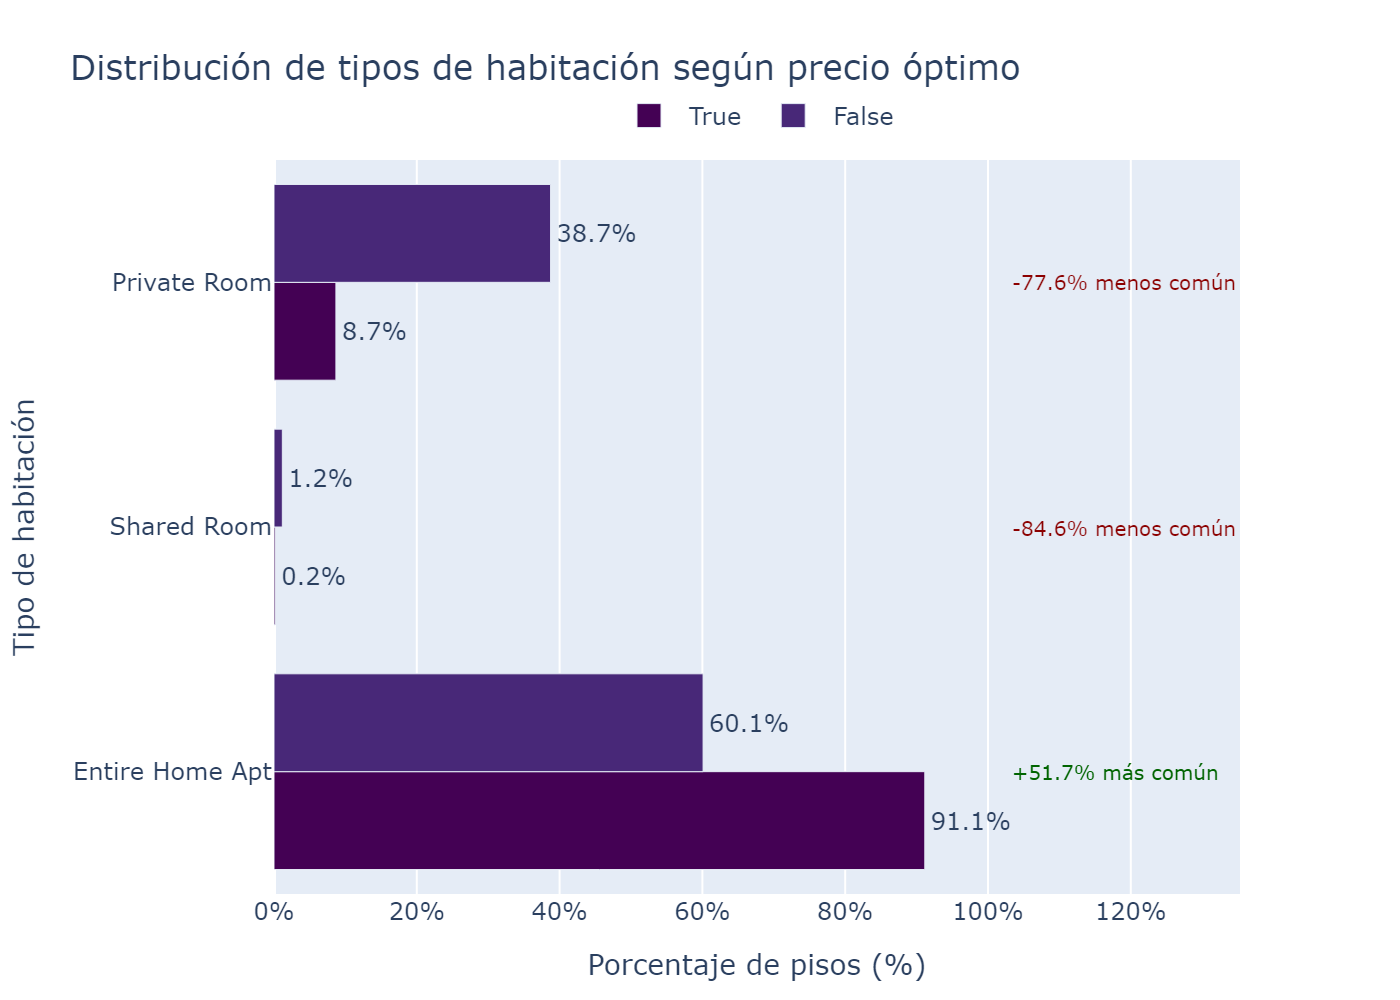

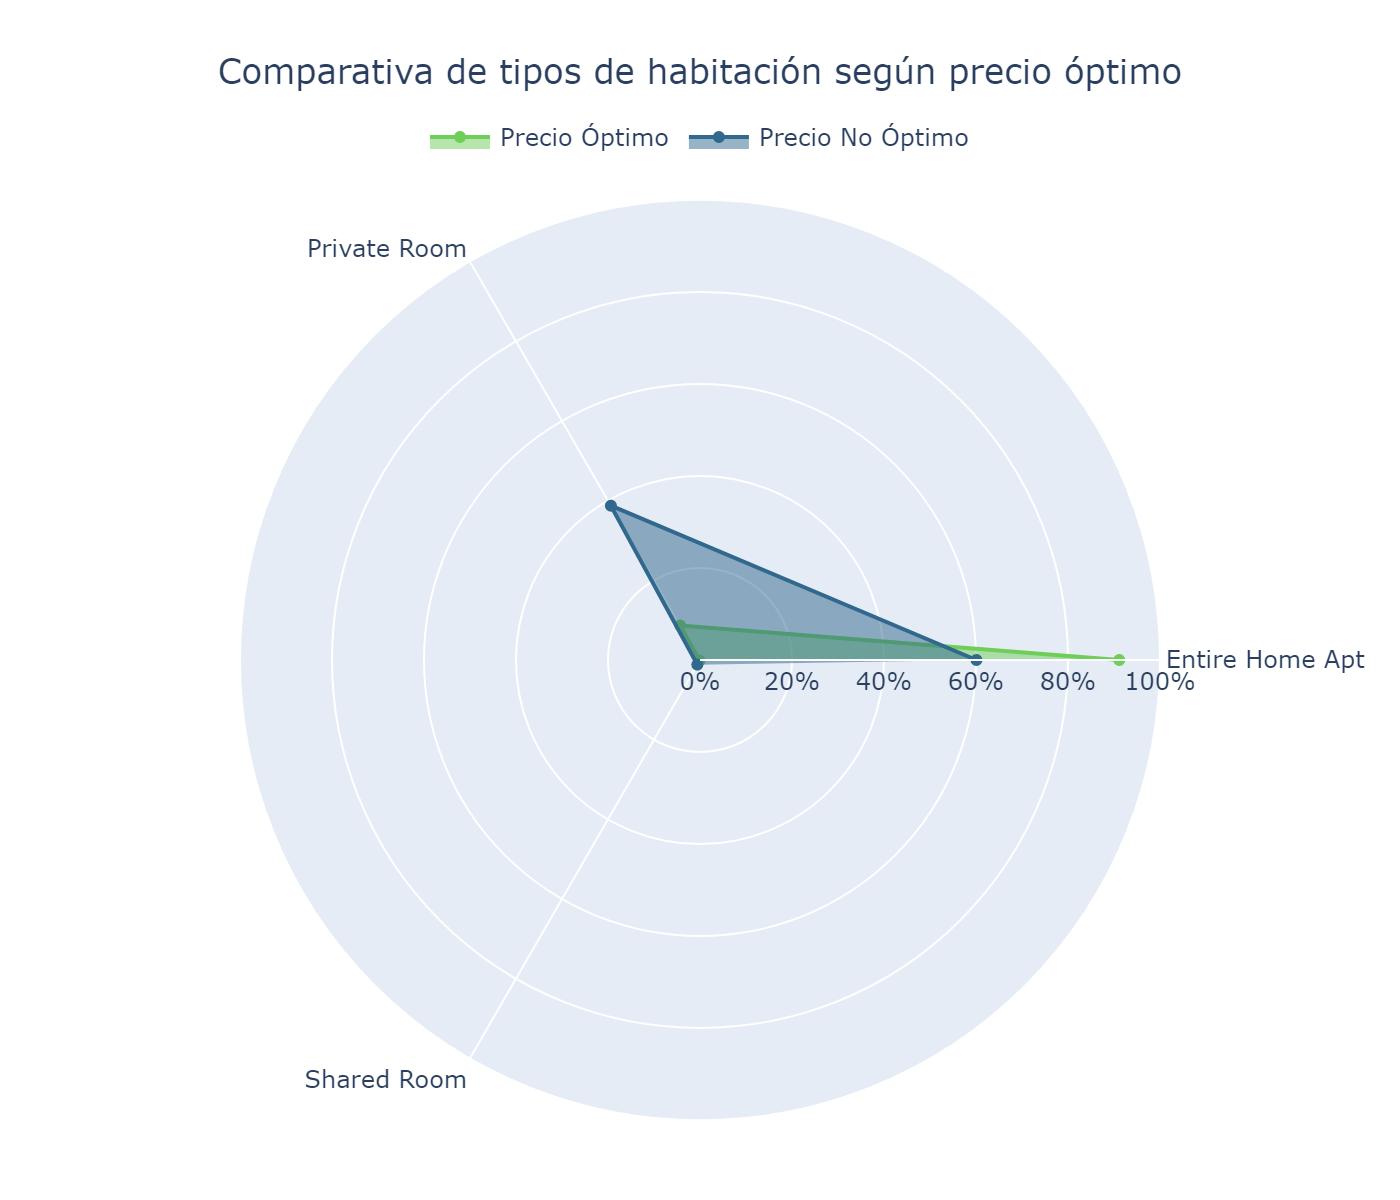

In [23]:
# Crear variables dummies para room_type
df_room_dummies = pd.get_dummies(df['room_type'], prefix='room_type')

# Calcular el porcentaje de pisos según el tipo de habitación
df_room_stats = df[['precio_optimo']].join(df_room_dummies).groupby('precio_optimo', as_index=False).mean()

# Transformar los datos para la visualización
df_room_stats = (
    df_room_stats
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "room_type", "value": "porcentaje"})
)

# Mejorar los nombres de las categorías
nombre_room_type = {
    col: col.replace("room_type_", "").replace("_", " ").title()
    for col in df_room_dummies.columns
}

df_room_stats["room_type_nombre"] = df_room_stats["room_type"].map(nombre_room_type)

# Calcular diferencia porcentual
pivot_df = df_room_stats.pivot(index='room_type', columns='precio_optimo', values='porcentaje').reset_index()
pivot_df['diferencia'] = pivot_df[True] - pivot_df[False]
pivot_df['diferencia_porcentual'] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_final = pd.merge(
    df_room_stats,
    pivot_df[['room_type', 'diferencia', 'diferencia_porcentual']],
    on='room_type'
)

# Ordenar por la diferencia
top_room_types = pivot_df.sort_values('diferencia', ascending=False)['room_type'].tolist()
df_final['room_type_orden'] = pd.Categorical(df_final['room_type'], categories=top_room_types, ordered=True)

# Gráfico de barras
fig = px.bar(
    df_final.sort_values('room_type_orden'),
    y='room_type_nombre',
    x='porcentaje',
    color='precio_optimo',
    barmode='group',
    title='Distribución de tipos de habitación según precio óptimo',
    labels={
        'porcentaje': 'Porcentaje de pisos (%)',
        'room_type_nombre': 'Tipo de habitación',
        'precio_optimo': 'Precio'
    },
    category_orders={'precio_optimo': [True, False]},
    text_auto='.1%',
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        title_text='',
        orientation='h',
        yanchor='top',
        y=1.1,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(tickformat='.0%'),
    margin=dict(t=80, b=40),
    height=500
)

fig.update_traces(textposition='outside')

# Anotaciones con diferencias porcentuales
for i, room in enumerate(top_room_types):
    subset = df_final[df_final['room_type'] == room]
    diff_pct = subset['diferencia_porcentual'].values[0]

    if abs(diff_pct) > 1:
        y_pos = nombre_room_type[room]
        texto = f"+{diff_pct:.1f}% más común" if diff_pct > 0 else f"{diff_pct:.1f}% menos común"
        color = "darkgreen" if diff_pct > 0 else "darkred"

        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor='left',
            yanchor='middle',
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align='left',
            xshift=10
        )

fig.show()

# Gráfico de radar
radar_df = df_room_stats.pivot(index='precio_optimo', columns='room_type_nombre', values='porcentaje').reset_index()

fig_radar = go.Figure()

for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df['precio_optimo'] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = 'Precio Óptimo' if precio else 'Precio No Óptimo'
        color = px.colors.sequential.Viridis[7] if precio else px.colors.sequential.Viridis[3]
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill='toself',
            name=nombre,
            line_color=color
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat='.0%'
        )
    ),
    title={
        'text': 'Comparativa de tipos de habitación según precio óptimo',
        'y': 0.95,
        'x': 0.5
    },
    showlegend=True,
    legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='center', x=0.5),
    margin=dict(t=100, b=40),
    height=600
)

fig_radar.show()
# fig.write_image("../docs/comparativa_rooms_precio.png", scale=2)
# fig_radar.write_image("../docs/comparativa_rooms_precio_radar.png", scale=2)
display(Image(filename="../docs/comparativa_rooms_precio.png"))
display(Image(filename="../docs/comparativa_rooms_precio_radar.png"))



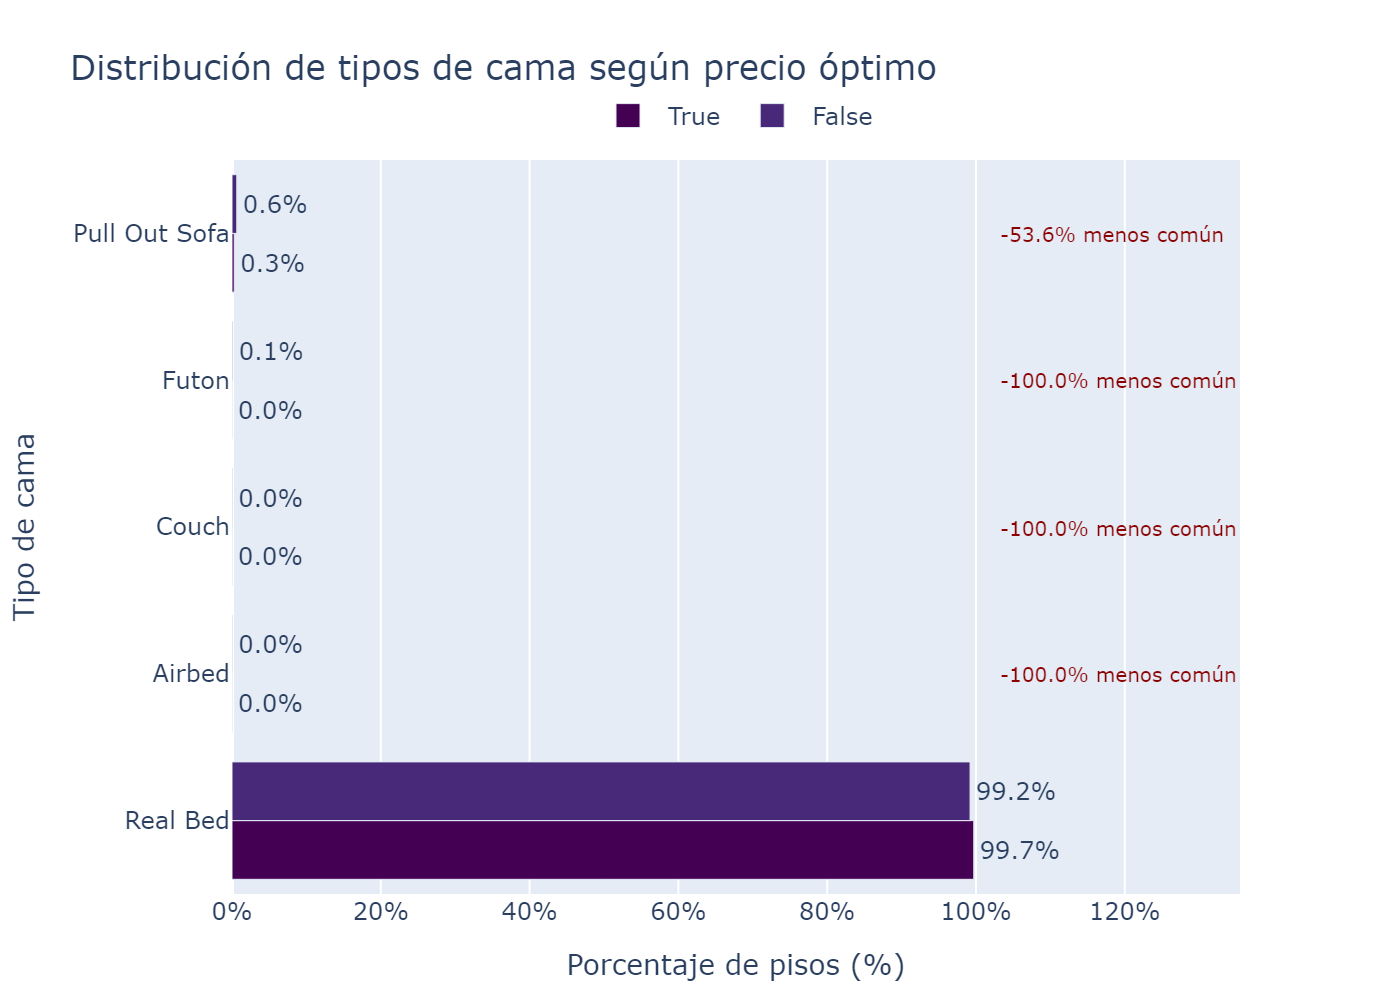

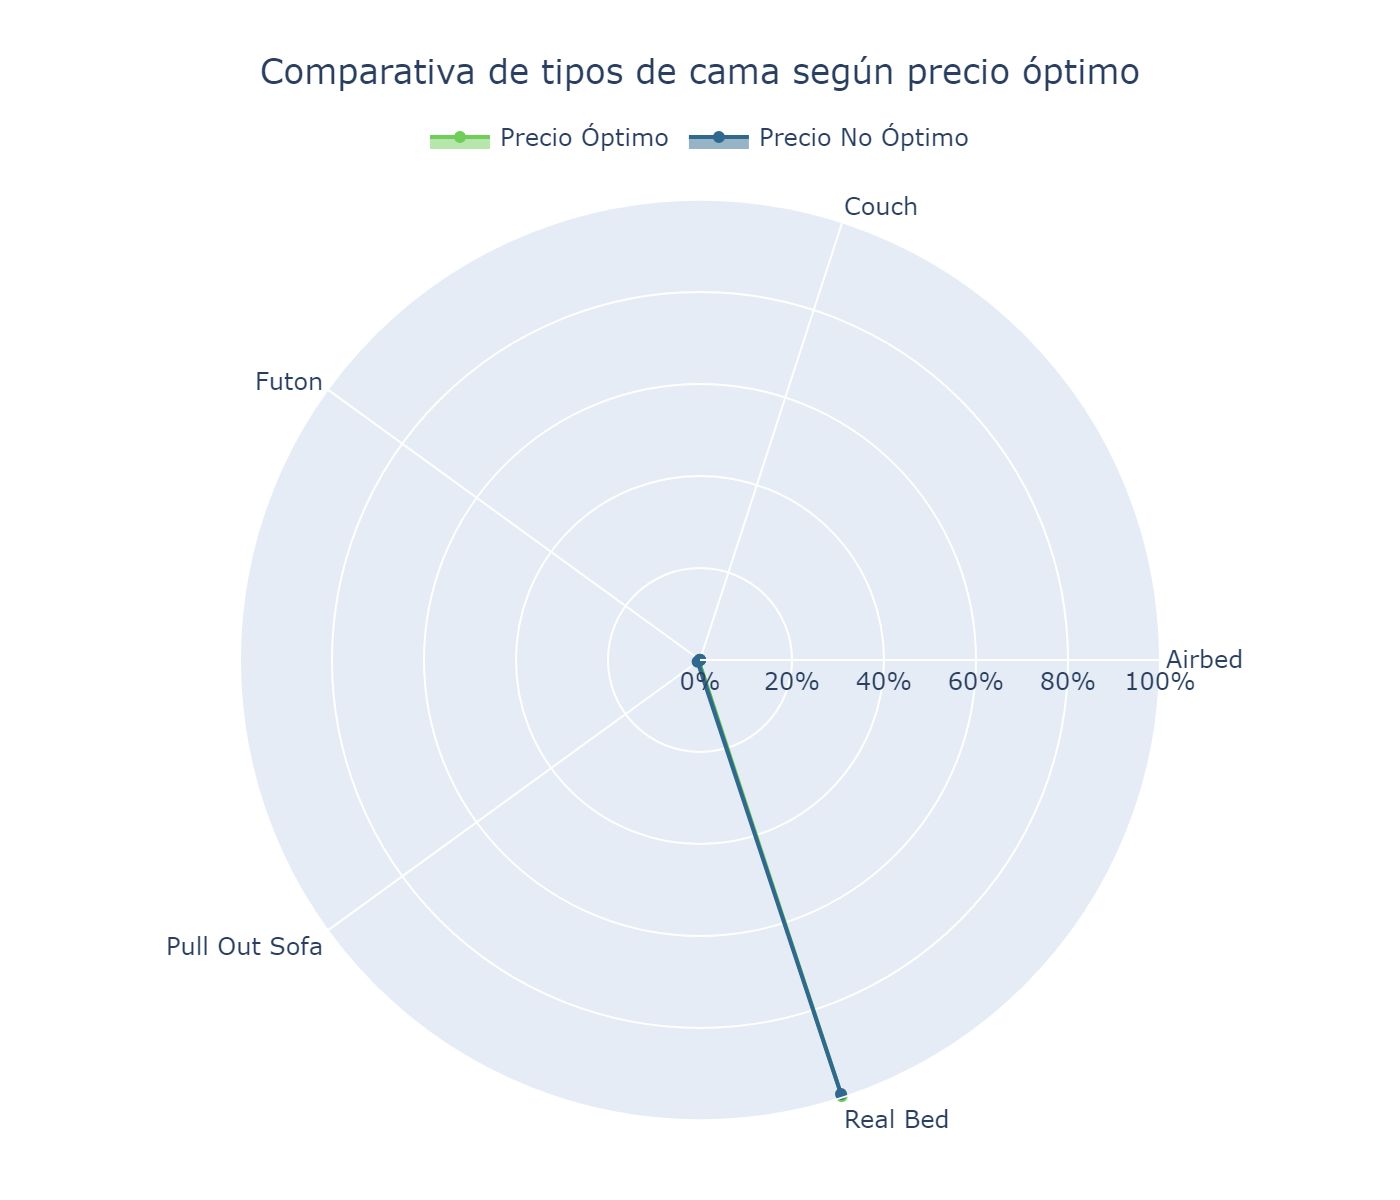

In [24]:
# Crear variables dummies para bed_type
df_bed_dummies = pd.get_dummies(df['bed_type'], prefix='bed_type')

# Calcular el porcentaje de pisos según el tipo de cama
df_bed_stats = df[['precio_optimo']].join(df_bed_dummies).groupby('precio_optimo', as_index=False).mean()

# Transformar los datos para la visualización
df_bed_stats = (
    df_bed_stats
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "bed_type", "value": "porcentaje"})
)

# Mejorar los nombres de las categorías
nombre_bed_type = {
    col: col.replace("bed_type_", "").replace("_", " ").title()
    for col in df_bed_dummies.columns
}

df_bed_stats["bed_type_nombre"] = df_bed_stats["bed_type"].map(nombre_bed_type)

# Calcular diferencia porcentual
pivot_df = df_bed_stats.pivot(index='bed_type', columns='precio_optimo', values='porcentaje').reset_index()
pivot_df['diferencia'] = pivot_df[True] - pivot_df[False]
pivot_df['diferencia_porcentual'] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_final = pd.merge(
    df_bed_stats,
    pivot_df[['bed_type', 'diferencia', 'diferencia_porcentual']],
    on='bed_type'
)

# Ordenar por la diferencia
top_bed_types = pivot_df.sort_values('diferencia', ascending=False)['bed_type'].tolist()
df_final['bed_type_orden'] = pd.Categorical(df_final['bed_type'], categories=top_bed_types, ordered=True)

# Gráfico de barras
fig = px.bar(
    df_final.sort_values('bed_type_orden'),
    y='bed_type_nombre',
    x='porcentaje',
    color='precio_optimo',
    barmode='group',
    title='Distribución de tipos de cama según precio óptimo',
    labels={
        'porcentaje': 'Porcentaje de pisos (%)',
        'bed_type_nombre': 'Tipo de cama',
        'precio_optimo': 'Precio'
    },
    category_orders={'precio_optimo': [True, False]},
    text_auto='.1%',
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        title_text='',
        orientation='h',
        yanchor='top',
        y=1.1,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(tickformat='.0%'),
    margin=dict(t=80, b=40),
    height=500
)

fig.update_traces(textposition='outside')

# Anotaciones con diferencias porcentuales
for i, bed in enumerate(top_bed_types):
    subset = df_final[df_final['bed_type'] == bed]
    diff_pct = subset['diferencia_porcentual'].values[0]

    if abs(diff_pct) > 1:
        y_pos = nombre_bed_type[bed]
        texto = f"+{diff_pct:.1f}% más común" if diff_pct > 0 else f"{diff_pct:.1f}% menos común"
        color = "darkgreen" if diff_pct > 0 else "darkred"

        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor='left',
            yanchor='middle',
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align='left',
            xshift=10
        )

fig.show()

# Gráfico de radar
radar_df = df_bed_stats.pivot(index='precio_optimo', columns='bed_type_nombre', values='porcentaje').reset_index()

fig_radar = go.Figure()

for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df['precio_optimo'] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = 'Precio Óptimo' if precio else 'Precio No Óptimo'
        color = px.colors.sequential.Viridis[7] if precio else px.colors.sequential.Viridis[3]
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill='toself',
            name=nombre,
            line_color=color
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat='.0%'
        )
    ),
    title={
        'text': 'Comparativa de tipos de cama según precio óptimo',
        'y': 0.95,
        'x': 0.5
    },
    showlegend=True,
    legend=dict(orientation='h', yanchor='top', y=1.1, xanchor='center', x=0.5),
    margin=dict(t=100, b=40),
    height=600
)

fig_radar.show()

# fig.write_image("../docs/comparativa_camas_precio.png", scale=2)
# fig_radar.write_image("../docs/comparativa_camas_precio_radar.png", scale=2)
display(Image(filename="../docs/comparativa_camas_precio.png"))
display(Image(filename="../docs/comparativa_camas_precio_radar.png"))


# 5. Análisis contractual

In [25]:
df['minimum_nights'].unique()

array([   1,    4,   15,    3,    5,    2,   28,    8,   25,    7,   12,
         10,    6,   30,   20,   90,   55,    9,  120,  180,   14,  270,
         60,  200,   13,  100,  365,   17,   75,   50,  364,   70,   40,
         27,  110,   61,  300,   29,   16,   21,  210,  150,  330,   24,
         26,   32,   11,   80,  178,   58,   56,   31,   59,   35,  289,
       1124,   45,   18,  130,   85,  999,  113,   57,   89,  350,   22],
      dtype=int64)

In [26]:

variable_analisis = 'minimum_nights'
Q1 = np.percentile(df[variable_analisis], 25)
Q3 = np.percentile(df[variable_analisis], 75)

IQR = Q3 - Q1

print('Valor del primer cuartil (25%): {:.2f}'.format(Q1))
print('Valor del tercer cuartil (75%): {:.2f}'.format(Q3))
print('Valor del rango intercuartil (IQR): {:.2f}'.format(IQR))

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print('\n')
print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")
print('\n')

# Se eliminan los outliers del límite superior
df = df[df[variable_analisis] <= limite_superior]

# Marcar que ya se ejecutó
outliers_eliminados = True  

print(f"Se eliminaron los valores mayores a {limite_superior:.2f} en '{variable_analisis}'.")
print(f"Nuevo tamaño del DataFrame: {df.shape}")



Valor del primer cuartil (25%): 1.00
Valor del tercer cuartil (75%): 3.00
Valor del rango intercuartil (IQR): 2.00


Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:
	 - Límite inferior (considerado extremadamente bajo): -2.00
	 - Límite superior (considerado extremadamente alto): 6.00


Se eliminaron los valores mayores a 6.00 en 'minimum_nights'.
Nuevo tamaño del DataFrame: (12981, 55)


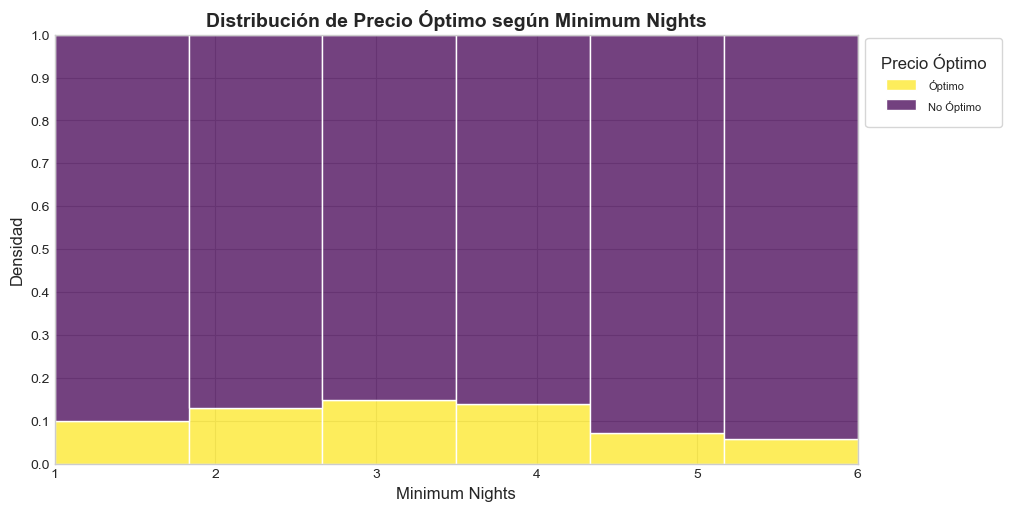

Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de minimum nights:
- 2.0: 39.46% del total
- 1.0: 31.01% del total
- 3.0: 22.89% del total


,Minimum Nights,% Distribución Óptimos
0,1,31.01%
1,2,39.46%
2,3,22.89%
3,4,4.38%
4,5,1.93%
5,6,0.32%


In [27]:
# Crear figura
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Paleta personalizada
paleta_personalizada = ["#440154", "#FDE725"]

# Gráfico de histogramas con bins
sns.histplot(
    data=df,
    x="minimum_nights",
    hue="precio_optimo",
    multiple="fill",
    bins=int(df["minimum_nights"].max()),  # Un bin por número entero
    palette=paleta_personalizada,
    ax=ax
)

# Títulos y etiquetas
ax.set_title("Distribución de Precio Óptimo según Minimum Nights", fontsize=14, fontweight="bold")
ax.set_xlabel("Minimum Nights", fontsize=12) 
ax.set_ylabel("Densidad", fontsize=12)

# Ajustar el eje X para que use valores enteros
ax.set_xticks(np.arange(df["minimum_nights"].min(), df["minimum_nights"].max() + 1, 1))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Ajustar el eje X a los valores reales
ax.set_xlim(df["minimum_nights"].min(), df["minimum_nights"].max())

# Leyenda
leg = ax.legend(
    title="Precio Óptimo",
    labels=["Óptimo", "No Óptimo"],
    title_fontsize=12,
    fontsize=11,
    loc="upper left",
    bbox_to_anchor=(1, 1.01),
    frameon=True,
    borderpad=1,
)

# Tamaño fuente leyenda
for text in leg.get_texts():
    text.set_fontsize(8)

# Mostrar gráfico
plt.show()

# Calcular el porcentaje de pisos con precio óptimo por mínimo de noches
distribucion_optimos = (
    df[df["precio_optimo"] == True]
    .groupby("minimum_nights")["precio_optimo"]
    .count()
    .div(df["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_precios = distribucion_optimos.reset_index()
distribucion_precios.columns = ["Minimum Nights", "% Distribución Óptimos"]
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].round(2)  
distribucion_precios = distribucion_precios[distribucion_precios["% Distribución Óptimos"] > 0]

# Identificar los valores con mayor concentración de precios óptimos
top_rangos = distribucion_precios.sort_values(by="% Distribución Óptimos", ascending=False).head(3)

# Imprimir el comentario sobre la concentración
print("Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de minimum nights:")
for _, row in top_rangos.iterrows():
    print(f"- {row['Minimum Nights']}: {row['% Distribución Óptimos']:.2f}% del total")

# Convertir a string con % para mostrar en la tabla
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].apply(lambda x: f"{x}%")

# Mostrar la tabla
distribucion_precios


In [28]:
variable_analisis = 'maximum_nights'
Q1 = np.percentile(df[variable_analisis], 25)
Q3 = np.percentile(df[variable_analisis], 75)

IQR = Q3 - Q1

print('Valor del primer cuartil (25%): {:.2f}'.format(Q1))
print('Valor del tercer cuartil (75%): {:.2f}'.format(Q3))
print('Valor del rango intercuartil (IQR): {:.2f}'.format(IQR))

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print('\n')
print(f"Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:")
print(f"\t - Límite inferior (considerado extremadamente bajo): {limite_inferior:.2f}")
print(f"\t - Límite superior (considerado extremadamente alto): {limite_superior:.2f}")
print('\n')

# Se eliminan los outliers del límite superior
df = df[df[variable_analisis] <= limite_superior]

# Marcar que ya se ejecutó
outliers_eliminados = True  
print(f"Se eliminaron los valores mayores a {limite_superior:.2f} en '{variable_analisis}'.")
print(f"Nuevo tamaño del DataFrame: {df.shape}")

Valor del primer cuartil (25%): 33.00
Valor del tercer cuartil (75%): 1125.00
Valor del rango intercuartil (IQR): 1092.00


Los valores atípicos se definen como aquellos que caen fuera del siguiente rango:
	 - Límite inferior (considerado extremadamente bajo): -1605.00
	 - Límite superior (considerado extremadamente alto): 2763.00


Se eliminaron los valores mayores a 2763.00 en 'maximum_nights'.
Nuevo tamaño del DataFrame: (12975, 55)


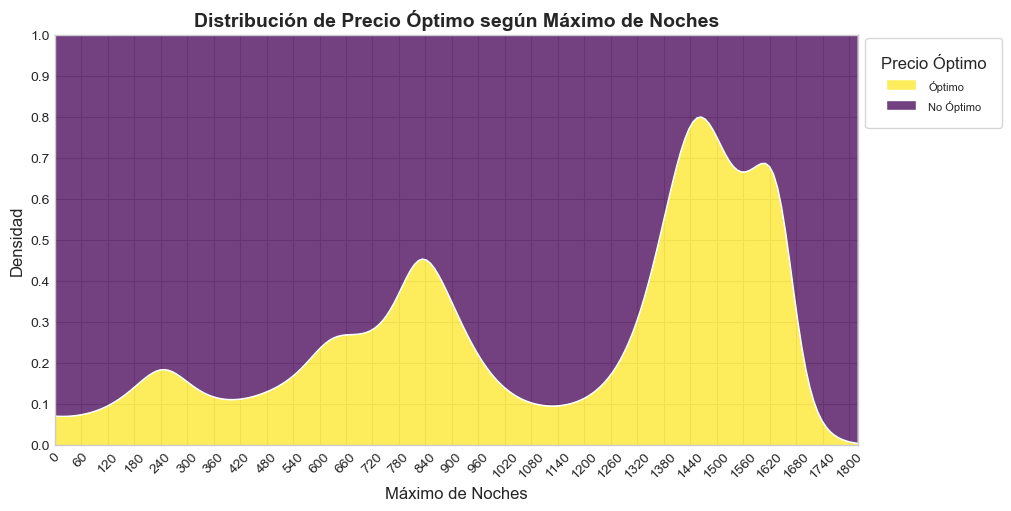

Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de maximum nights:
- 1125.0: 60.22% del total
- 30.0: 6.00% del total
- 999.0: 3.09% del total


,Maximum Nights,% Distribución Óptimos
0,1,0.06%
1,2,0.45%
2,3,1.16%
3,4,0.64%
4,5,0.71%
...,...,...
68,1120,0.13%
69,1123,0.06%
70,1124,3.03%
71,1125,60.22%


In [29]:
# Crear una copia del DataFrame sin NaN en maximum_nights
df_max_nights = df.dropna(subset=["maximum_nights"]).copy()
df_max_nights["maximum_nights"] = df_max_nights["maximum_nights"].astype(int)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Paleta personalizada
paleta_personalizada = ["#440154", "#FDE725"]

# Gráfico KDE con ajuste de suavidad y evitando valores negativos
sns.kdeplot(
    data=df_max_nights,
    x="maximum_nights",
    hue="precio_optimo",
    multiple="fill",
    palette=paleta_personalizada,
    ax=ax,
    clip=(0, 1820) 
)

# Títulos y etiquetas en castellano
ax.set_title("Distribución de Precio Óptimo según Máximo de Noches", fontsize=14, fontweight="bold")
ax.set_xlabel("Máximo de Noches", fontsize=12) 
ax.set_ylabel("Densidad", fontsize=12)

# Ajustar el eje X para que use intervalos de 60 en 60
ax.set_xticks(np.arange(0, 1821, 60))
ax.set_xlim(0, 1820)

# Ajustar el eje Y
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Rotar etiquetas del eje X para mejor visibilidad
ax.tick_params(axis="x", rotation=45)

# Leyenda
leg = ax.legend(
    title="Precio Óptimo",
    labels=["Óptimo", "No Óptimo"],
    title_fontsize=12,
    fontsize=11,
    loc="upper left",
    bbox_to_anchor=(1, 1.01),
    frameon=True,
    borderpad=1,
)

# Tamaño fuente leyenda
for text in leg.get_texts():
    text.set_fontsize(8)

# Mostrar gráfico
plt.show()



# Calcular el porcentaje de pisos con precio óptimo por máximo de noches
distribucion_optimos = (
    df_max_nights[df_max_nights["precio_optimo"] == True]
    .groupby("maximum_nights")["precio_optimo"]
    .count()
    .div(df_max_nights["precio_optimo"].sum()) * 100
)

# Crear la tabla y eliminar valores con 0%
distribucion_precios = distribucion_optimos.reset_index()
distribucion_precios.columns = ["Maximum Nights", "% Distribución Óptimos"]
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].round(2)  
distribucion_precios = distribucion_precios[distribucion_precios["% Distribución Óptimos"] > 0]

# Identificar los valores con mayor concentración de precios óptimos
top_rangos = distribucion_precios.sort_values(by="% Distribución Óptimos", ascending=False).head(3)

# Imprimir el comentario sobre la concentración
print("Las mayores concentraciones de pisos con precio óptimo se encuentran en los siguientes valores de maximum nights:")
for _, row in top_rangos.iterrows():
    print(f"- {row['Maximum Nights']}: {row['% Distribución Óptimos']:.2f}% del total")

# Convertir a string con % para mostrar en la tabla
distribucion_precios["% Distribución Óptimos"] = distribucion_precios["% Distribución Óptimos"].apply(lambda x: f"{x}%")

# Mostrar la tabla
distribucion_precios


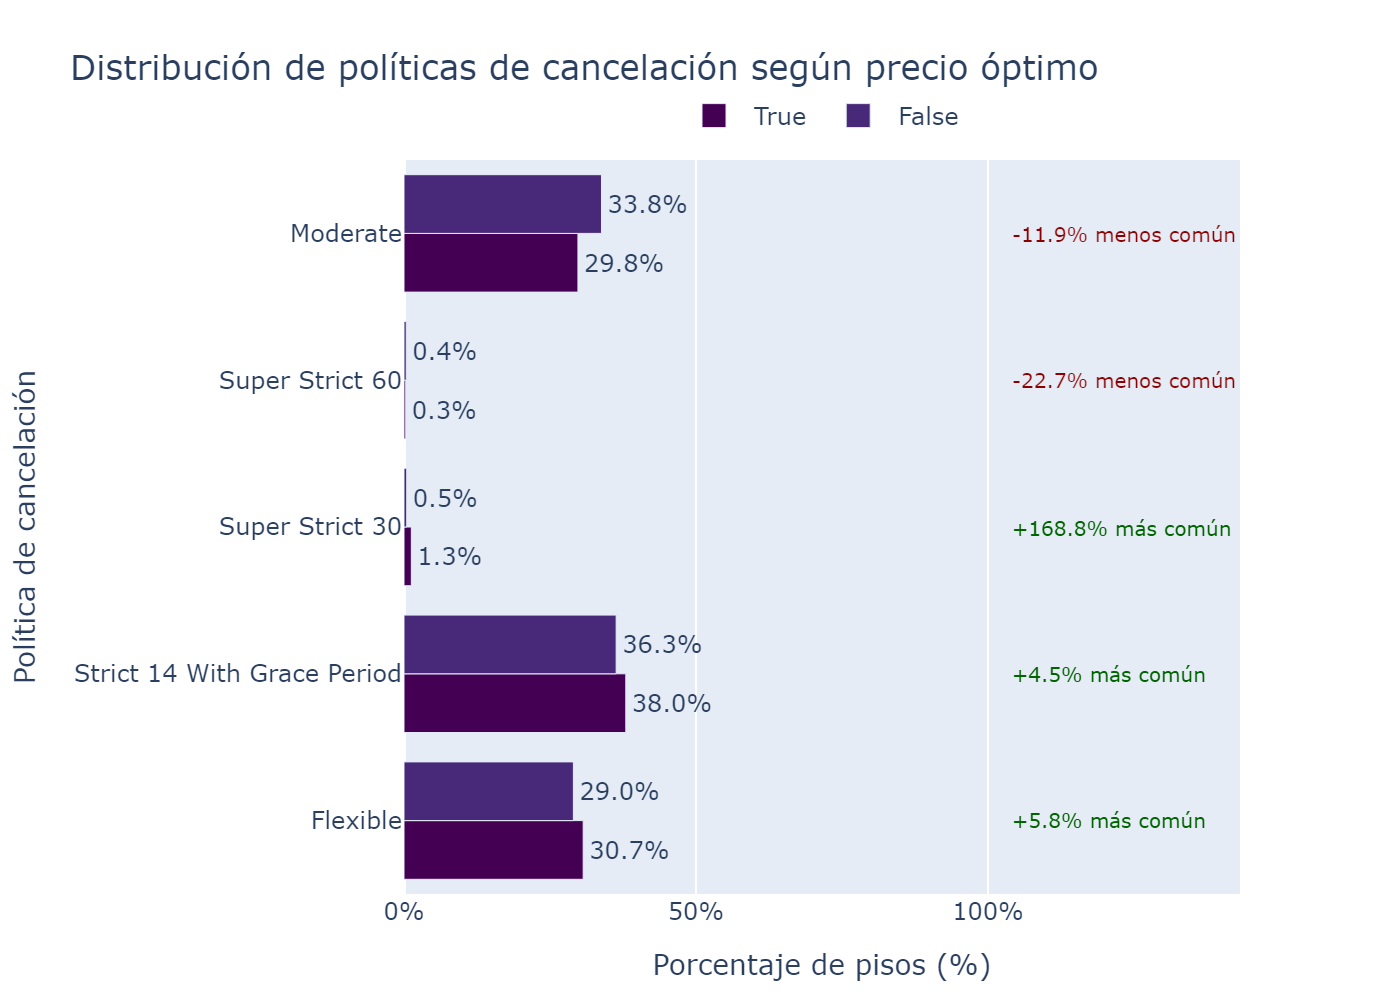

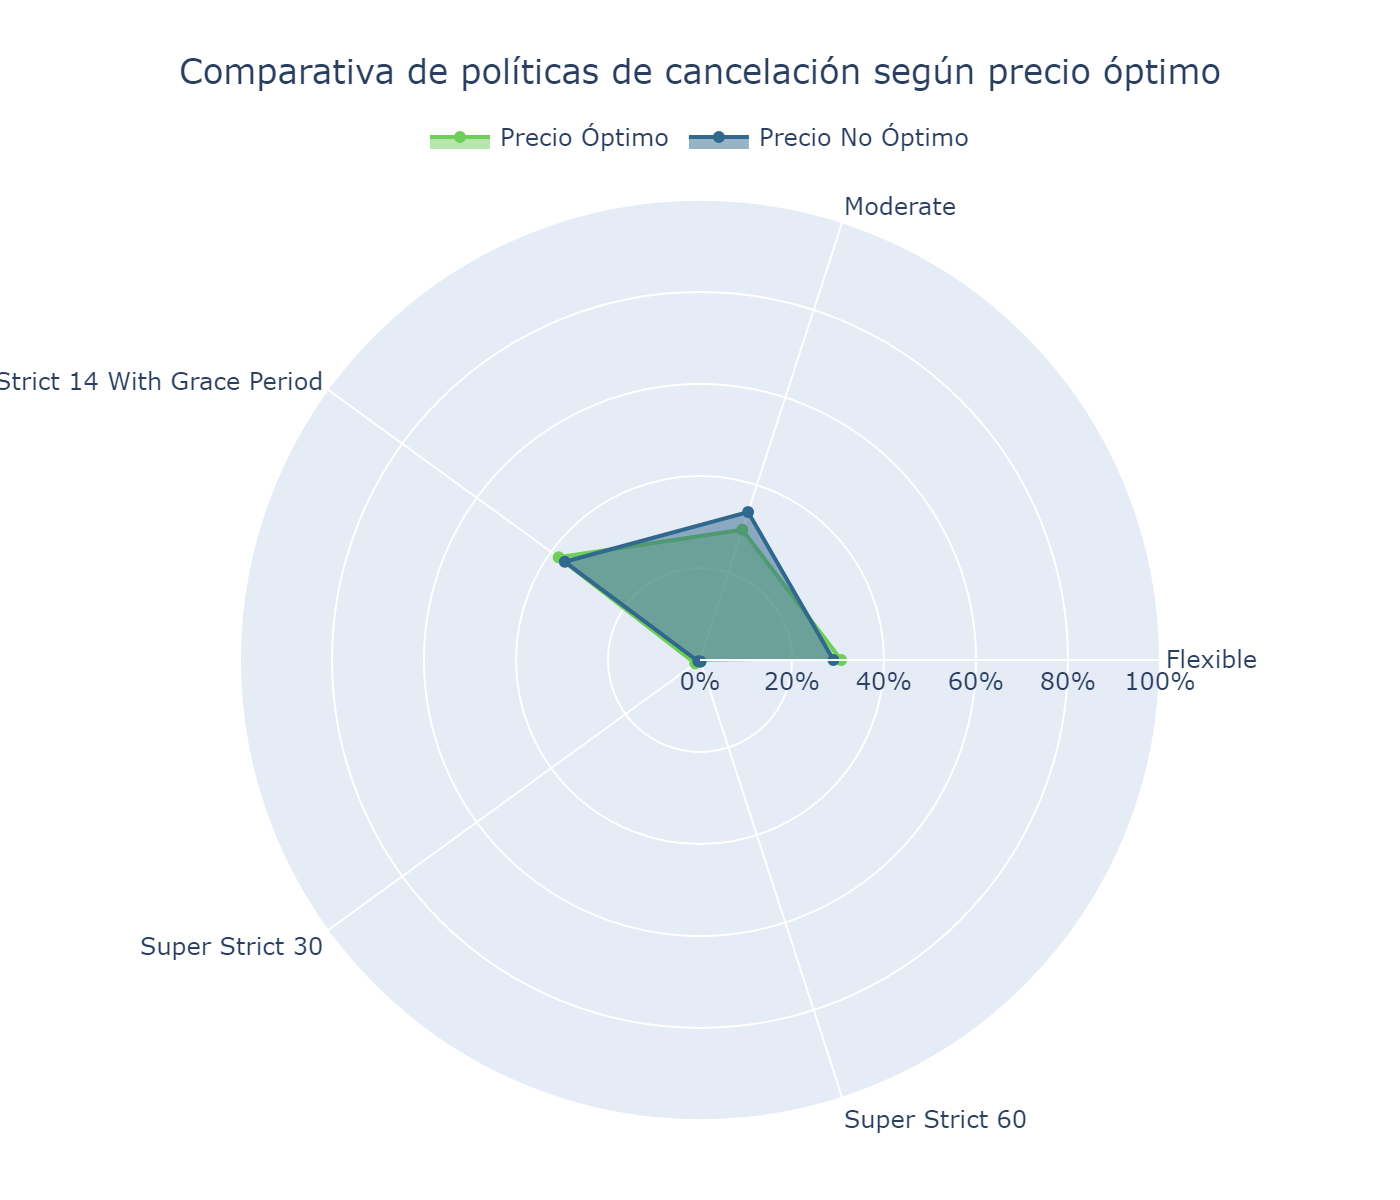

In [30]:
# Crear variables dummies para cancellation_policy
df_cancel_dummies = pd.get_dummies(df["cancellation_policy"], prefix="cancellation")

# Calcular el porcentaje de pisos según la política de cancelación
df_cancel_stats = df[["precio_optimo"]].join(df_cancel_dummies).groupby("precio_optimo", as_index=False).mean()

# Transformar los datos para la visualización
df_cancel_stats = (
    df_cancel_stats
    .set_index("precio_optimo")
    .transpose()
    .reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "cancellation_policy", "value": "porcentaje"})
)

# Mejorar los nombres de las categorías
nombre_cancel_policy = {
    col: col.replace("cancellation_", "").replace("_", " ").title()
    for col in df_cancel_dummies.columns
}

df_cancel_stats["cancellation_policy_nombre"] = df_cancel_stats["cancellation_policy"].map(nombre_cancel_policy)

# Calcular diferencia porcentual
pivot_df = df_cancel_stats.pivot(index="cancellation_policy", columns="precio_optimo", values="porcentaje").reset_index()
pivot_df["diferencia"] = pivot_df[True] - pivot_df[False]
pivot_df["diferencia_porcentual"] = ((pivot_df[True] / pivot_df[False]) - 1) * 100

# Unir la diferencia al dataframe original
df_final = pd.merge(
    df_cancel_stats,
    pivot_df[["cancellation_policy", "diferencia", "diferencia_porcentual"]],
    on="cancellation_policy"
)

# Ordenar por la diferencia
top_policies = pivot_df.sort_values("diferencia", ascending=False)["cancellation_policy"].tolist()
df_final["cancellation_policy_orden"] = pd.Categorical(df_final["cancellation_policy"], categories=top_policies, ordered=True)

# Gráfico de barras
fig = px.bar(
    df_final.sort_values("cancellation_policy_orden"),
    y="cancellation_policy_nombre",
    x="porcentaje",
    color="precio_optimo",
    barmode="group",
    title="Distribución de políticas de cancelación según precio óptimo",
    labels={
        "porcentaje": "Porcentaje de pisos (%)",
        "cancellation_policy_nombre": "Política de cancelación",
        "precio_optimo": "Precio"
    },
    category_orders={"precio_optimo": [True, False]},
    text_auto=".1%",
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Personalizar la leyenda
fig.update_layout(
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    xaxis=dict(tickformat=".0%"),
    margin=dict(t=80, b=40),
    height=500
)

fig.update_traces(textposition="outside")

# Anotaciones con diferencias porcentuales
for i, policy in enumerate(top_policies):
    subset = df_final[df_final["cancellation_policy"] == policy]
    diff_pct = subset["diferencia_porcentual"].values[0]

    if abs(diff_pct) > 1:
        y_pos = nombre_cancel_policy[policy]
        texto = f"+{diff_pct:.1f}% más común" if diff_pct > 0 else f"{diff_pct:.1f}% menos común"
        color = "darkgreen" if diff_pct > 0 else "darkred"

        fig.add_annotation(
            x=1,
            y=y_pos,
            xanchor="left",
            yanchor="middle",
            text=texto,
            showarrow=False,
            font=dict(size=10, color=color),
            align="left",
            xshift=10
        )

fig.show()

# Gráfico de radar
radar_df = df_cancel_stats.pivot(index="precio_optimo", columns="cancellation_policy_nombre", values="porcentaje").reset_index()

fig_radar = go.Figure()

for i, precio in enumerate([True, False]):
    subset = radar_df[radar_df["precio_optimo"] == precio]
    if not subset.empty:
        valores = subset.iloc[0, 1:].values.tolist()
        categorias = subset.columns[1:].tolist()
        
        nombre = "Precio Óptimo" if precio else "Precio No Óptimo"
        color = px.colors.sequential.Viridis[7] if precio else px.colors.sequential.Viridis[3]
        
        fig_radar.add_trace(go.Scatterpolar(
            r=valores,
            theta=categorias,
            fill="toself",
            name=nombre,
            line_color=color
        ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickformat=".0%"
        )
    ),
    title={
        "text": "Comparativa de políticas de cancelación según precio óptimo",
        "y": 0.95,
        "x": 0.5
    },
    showlegend=True,
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="center", x=0.5),
    margin=dict(t=100, b=40),
    height=600
)

fig_radar.show()

# fig.write_image("../docs/comparativa_reviews_precio.png", scale=2)
# fig_radar.write_image("../docs/comparativa_reviews_precio_radar.png", scale=2)
display(Image(filename="../docs/comparativa_reviews_precio.png"))
display(Image(filename="../docs/comparativa_reviews_precio_radar.png"))


# 6. Análisis de reseñas de clientes

                    Métrica  Correlación
0                 Ubicación     0.129012
1                  Limpieza     0.080517
2           Puntaje General     0.061217
3                 Precisión     0.040885
4              Comunicación     0.018495
5                  Check-in     0.007691
6         Número de Reseñas    -0.021006
7           Reseñas por Mes    -0.034977
8  Días desde Última Reseña    -0.083470


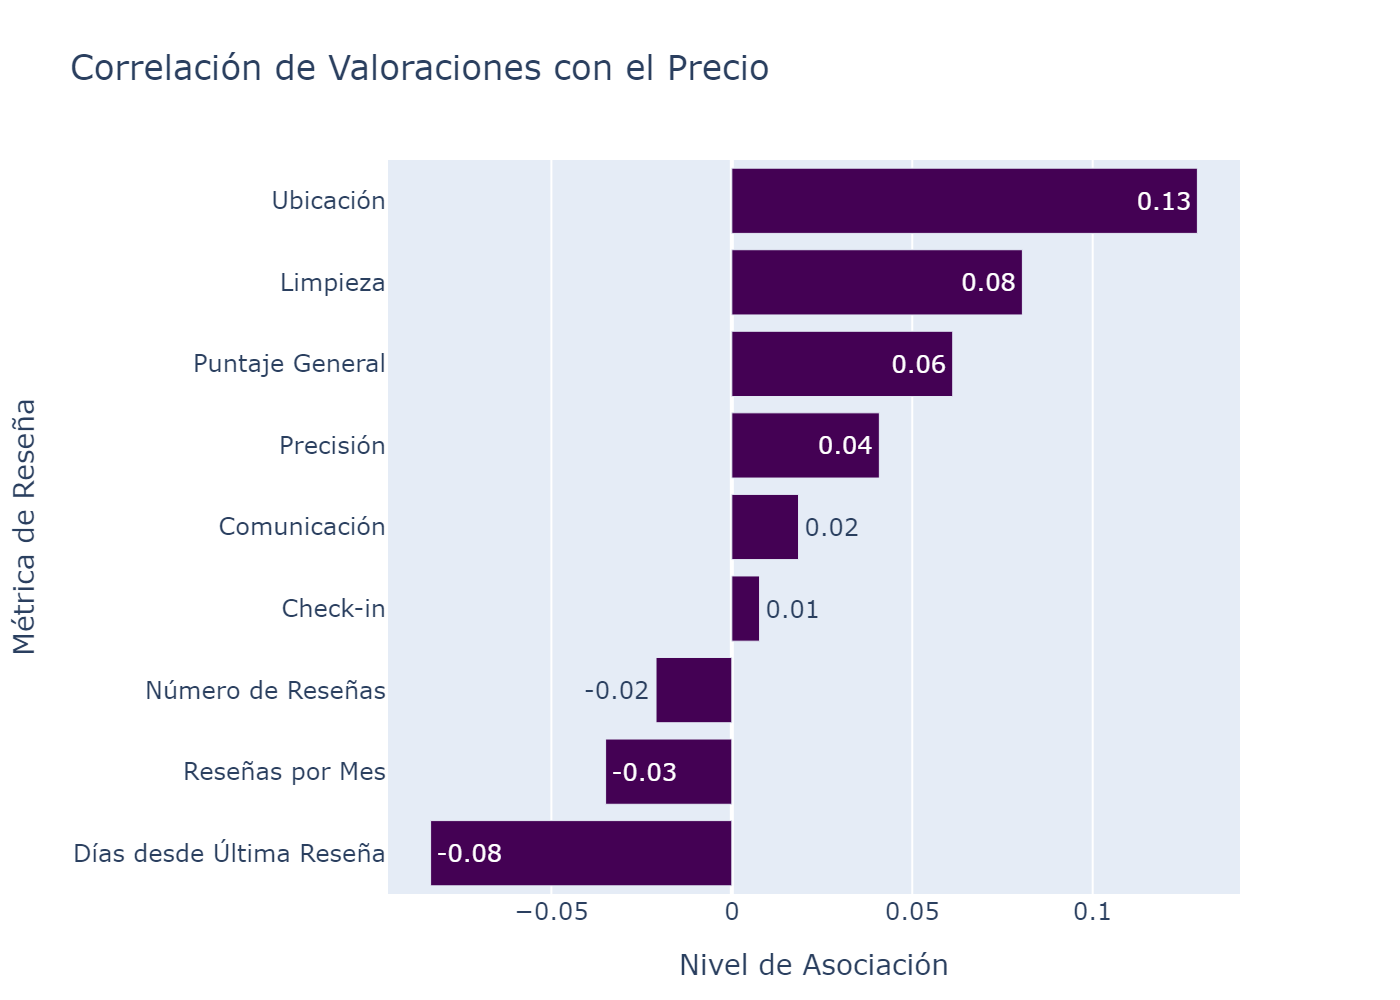

In [ ]:
# Definir las variables de reseñas
valoraciones = [
    'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'days_since_last_review', 'reviews_per_month'
]

# Crear un nuevo DataFrame para análisis sin afectar el original
df_reviews_analysis = df.copy()

# Manejo de NaN en variables de reseñas
df_reviews_analysis['days_since_last_review'] = df_reviews_analysis['days_since_last_review'].fillna(999)
df_reviews_analysis['reviews_per_month'] = df_reviews_analysis['reviews_per_month'].fillna(0)

# Rellenar NaN en puntajes con la mediana
for col in valoraciones:
    df_reviews_analysis[col] = df_reviews_analysis[col].fillna(df_reviews_analysis[col].median())

# Calcular correlaciones con el precio óptimo
correlaciones = df_reviews_analysis[valoraciones + ['price']].corr()['price'].drop('price').sort_values(ascending=False)

# Convertir a DataFrame para visualización
df_correlaciones = correlaciones.reset_index()
df_correlaciones.columns = ['Métrica', 'Correlación']
df_correlaciones['Métrica'] = df_correlaciones['Métrica'].replace({
    'number_of_reviews': 'Número de Reseñas',
    'review_scores_rating': 'Puntaje General',
    'review_scores_accuracy': 'Precisión',
    'review_scores_cleanliness': 'Limpieza',
    'review_scores_checkin': 'Check-in',
    'review_scores_communication': 'Comunicación',
    'review_scores_location': 'Ubicación',
    'days_since_last_review': 'Días desde Última Reseña',
    'reviews_per_month': 'Reseñas por Mes'
})

# Gráfico de barras
fig = px.bar(
    df_correlaciones.sort_values('Correlación', ascending=True),
    x='Correlación',
    y='Métrica',
    title='Correlación de Valoraciones con el Precio',
    labels={'Correlación': 'Nivel de Asociación', 'Métrica': 'Métrica de Reseña'},
    text_auto='.2f',
    color_discrete_sequence=px.colors.sequential.Viridis
)

fig.update_layout(
    margin=dict(t=80, b=40),
    height=500
)

fig.show()

# Mostrar la tabla con las correlaciones ordenadas
print(df_correlaciones)

# fig.write_image("../docs/correlaciones_reviews.png", scale=2)

display(Image(filename="../docs/correlaciones_reviews.png"))
